<a href="https://colab.research.google.com/github/connorvelliott/NavierStokesML/blob/main/Aero_689_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aero 689 Assignment 3 - Connor Elliott

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.9 MB/s eta 0:00:00


#Imports

In [ ]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend('tensorflow')

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


#VP Method

#Define Parameters

In [ ]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

#Boundary and Initial Conditions

In [ ]:
def boundary_wall(X, on_boundary):
  on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
  return on_wall

def boundary_inlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], L/2)

#Define PDE

In [ ]:
def pde(X, Y):
  du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
  du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
  dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
  dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
  dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
  dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
  du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
  du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
  dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
  dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)

  pde_u = Y[:, 0:1]*du_x + Y[:, 1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
  pde_v = Y[:, 0:1]*dv_x + Y[:, 1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
  pde_cont = du_x + dv_y

  return [pde_u, pde_v, pde_cont]

#Define Geometry and Implement BC

In [ ]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [ ]:
data = dde.data.PDE(geom, pde, [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v], num_domain = 2000, num_boundary = 200, num_test = 100)

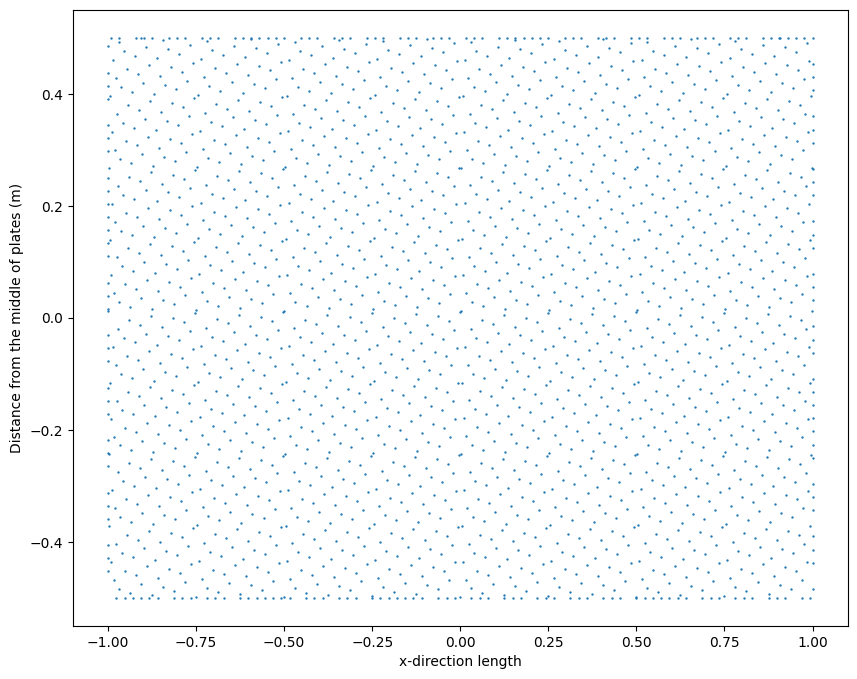

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

#Define Network and Hyper-Parameters

In [ ]:
layer_size = [2] + [64] * 5 + [3]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile('adam', lr = 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.137620 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.981934 s



#Train--ADAM Optimizer

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [8.06e-02, 6.38e-02, 1.39e-01, 8.69e-02, 2.96e-02, 1.97e+00, 7.85e-02, 2.03e-03, 7.83e-02]    [7.38e-02, 6.13e-02, 1.44e-01, 8.69e-02, 2.96e-02, 1.97e+00, 7.85e-02, 2.03e-03, 7.83e-02]    []  
1000      [6.50e-04, 6.05e-04, 9.14e-03, 2.85e-02, 1.63e-02, 3.84e-02, 2.13e-03, 5.47e-04, 4.55e-05]    [3.62e-04, 2.54e-04, 5.05e-03, 2.85e-02, 1.63e-02, 3.84e-02, 2.13e-03, 5.47e-04, 4.55e-05]    []  
2000      [1.59e-02, 1.43e-03, 3.87e-03, 2.25e-02, 1.22e-02, 3.12e-02, 6.13e-04, 7.89e-03, 4.52e-05]    [1.61e-02, 9.22e-04, 2.01e-03, 2.25e-02, 1.22e-02, 3.12e-02, 6.13e-04, 7.89e-03, 4.52e-05]    []  
3000      [7.49e-04, 7.69e-04, 3.71e-03, 1.91e-02, 1.07e-02, 2.28e-02, 1.80e-03, 8.84e-05, 1.98e-05]    [4.30e-04, 3.10e-04, 1.83e-03, 1.91e-02, 1.07e-02, 2.28e-0

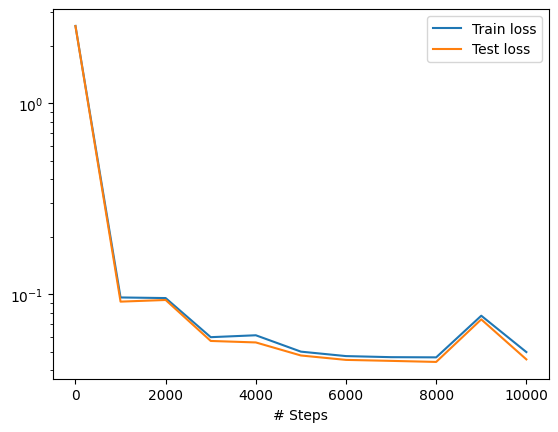

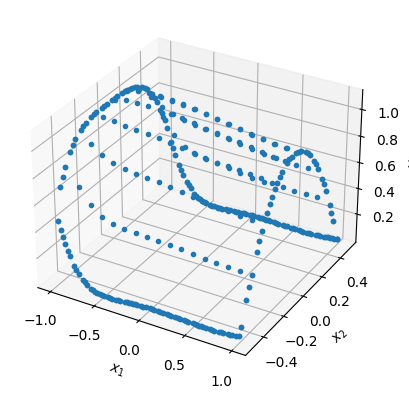

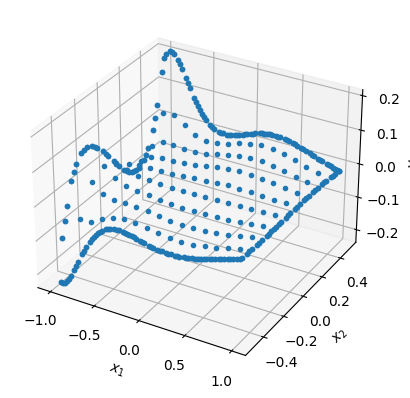

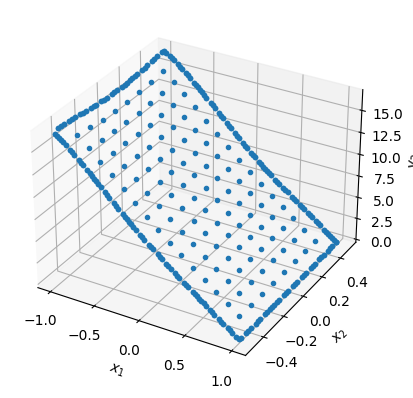

In [ ]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM Optimizer

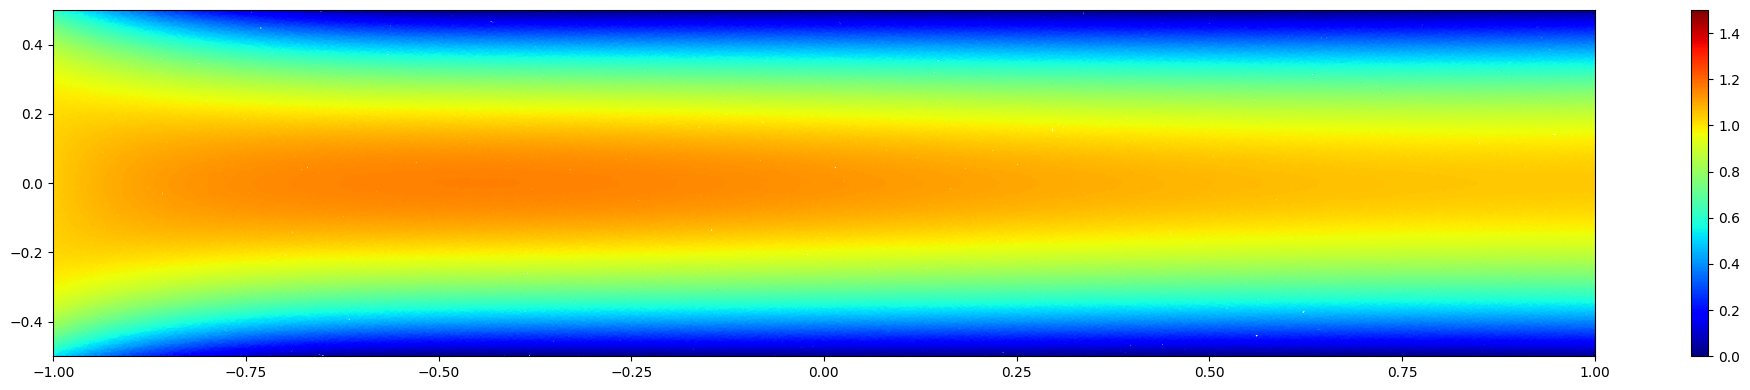

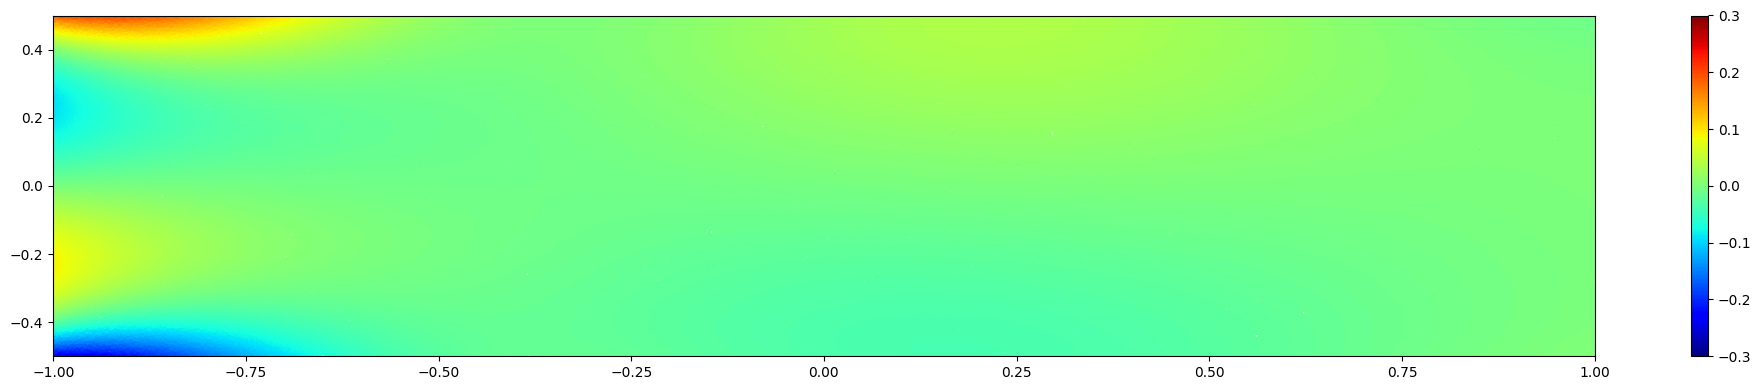

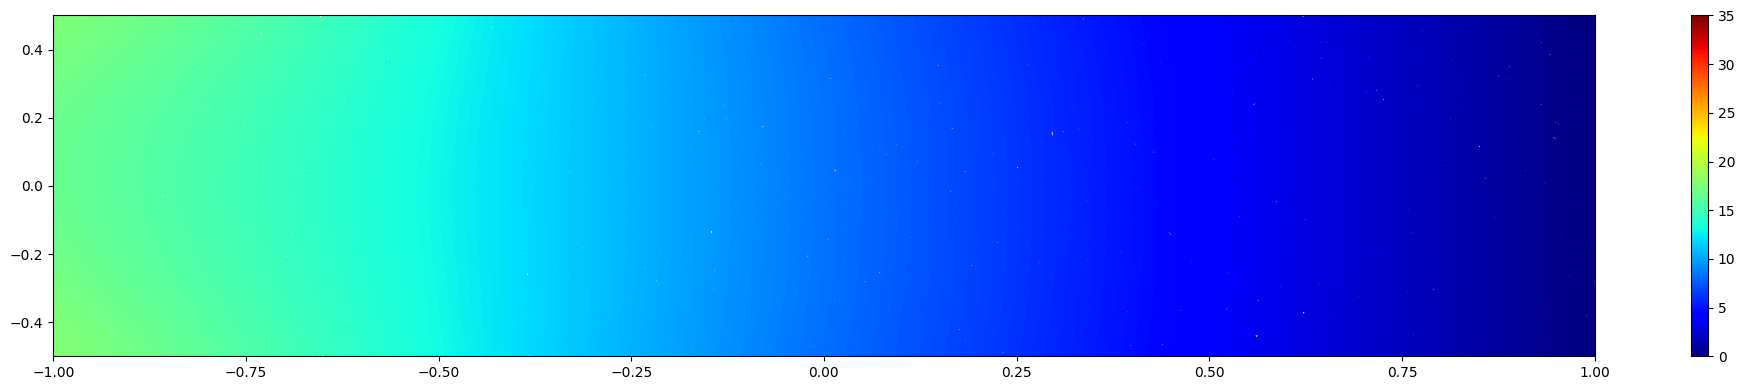

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20, 4))
  plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap = 'jet', s = 2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()

#Train More--L-BFGS Optimizer

Compiling model...
'compile' took 0.935172 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [5.65e-03, 1.84e-03, 2.35e-03, 1.45e-02, 5.73e-03, 1.47e-02, 5.13e-03, 1.94e-05, 8.16e-06]    [3.54e-03, 1.10e-03, 9.93e-04, 1.45e-02, 5.73e-03, 1.47e-02, 5.13e-03, 1.94e-05, 8.16e-06]    []  
11000     [5.37e-04, 5.39e-04, 7.64e-04, 6.49e-03, 1.35e-03, 6.38e-03, 2.07e-03, 2.57e-05, 7.71e-06]    [5.37e-04, 5.39e-04, 7.64e-04, 6.49e-03, 1.35e-03, 6.38e-03, 2.07e-03, 2.57e-05, 7.71e-06]        
12000     [3.72e-04, 4.57e-04, 5.12e-04, 4.51e-03, 9.35e-04, 4.16e-03, 1.31e-03, 2.88e-05, 1.68e-06]    [3.72e-04, 4.57e-04, 5.12e-04, 4.51e-03, 9.35e-04, 4.16e-03, 1.31e-03, 2.88e-05, 1.68e-06]        
13000     [2.95e-04, 3.61e-04, 5.93e-04, 3.19e-03, 7.50e-04, 3.01e-03, 8.41e-04, 2.56e-05, 1.04e-05]    [2.95e-04, 3

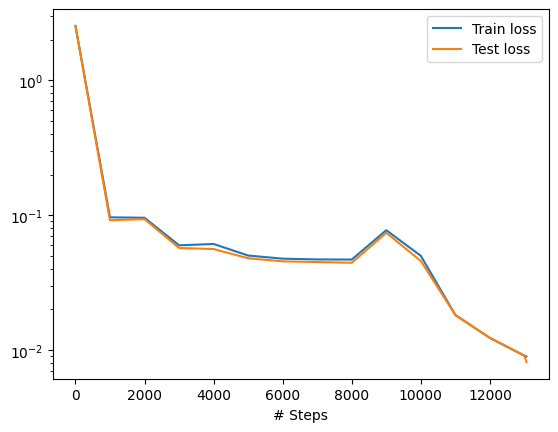

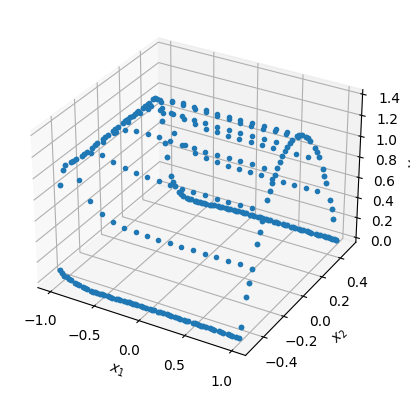

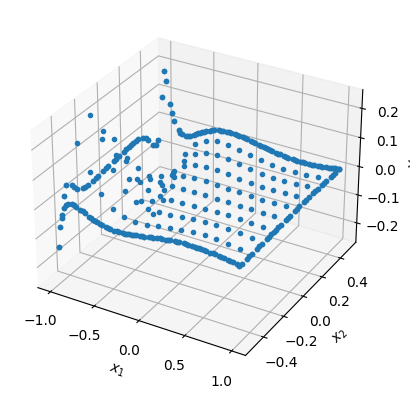

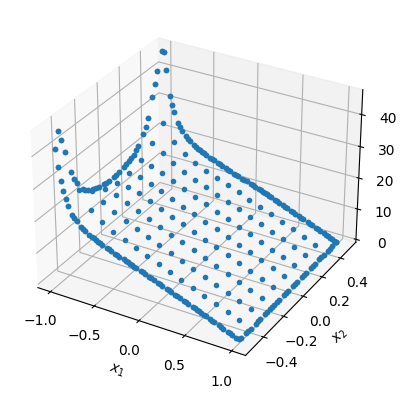

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)

model.compile('L-BFGS')
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM + L-BFGS

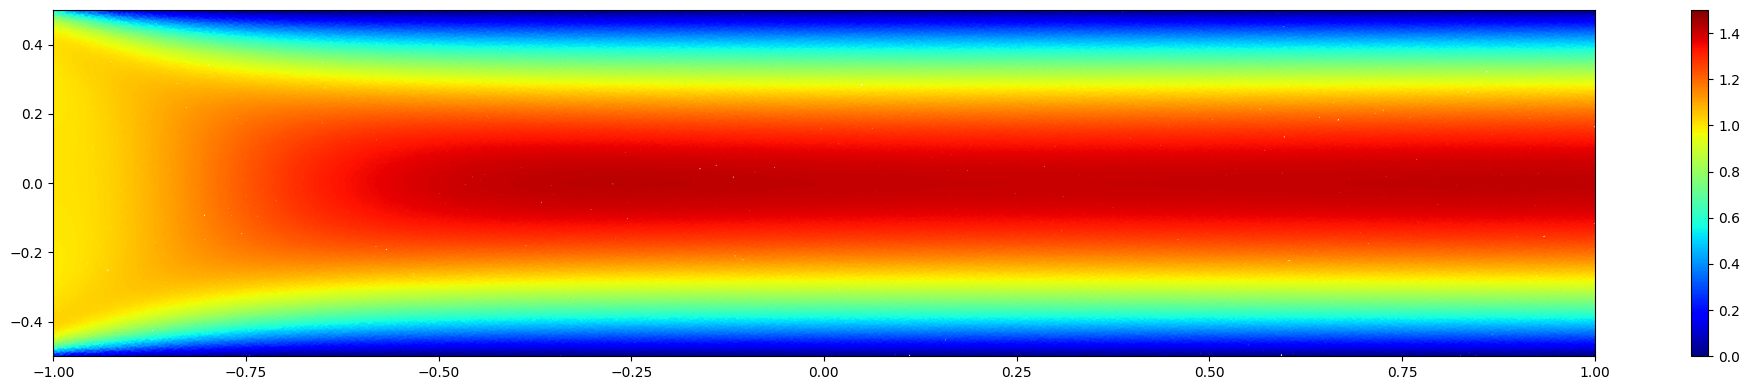

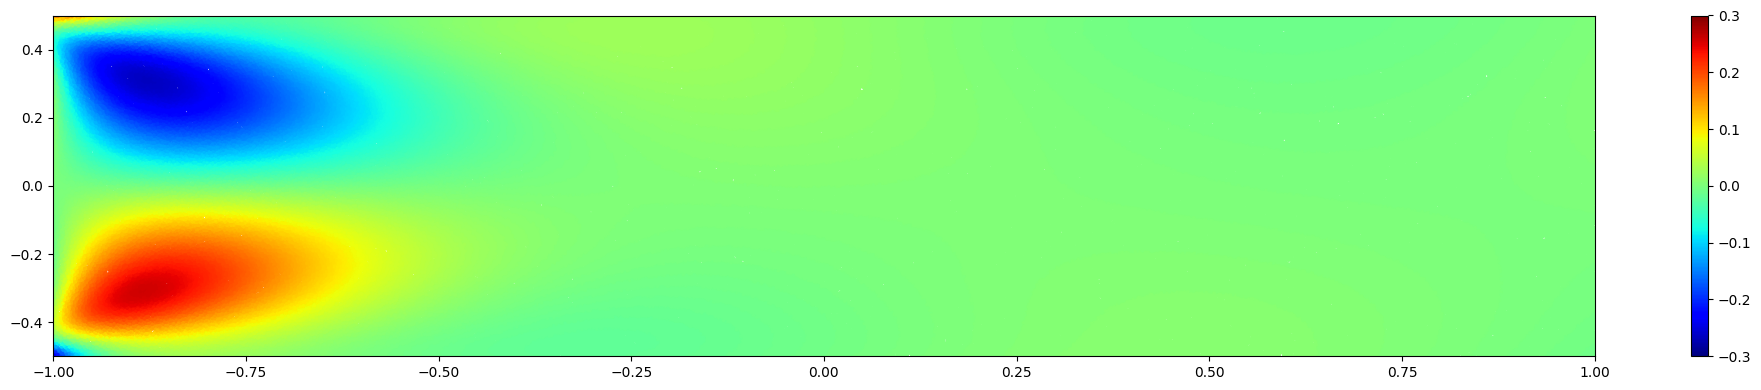

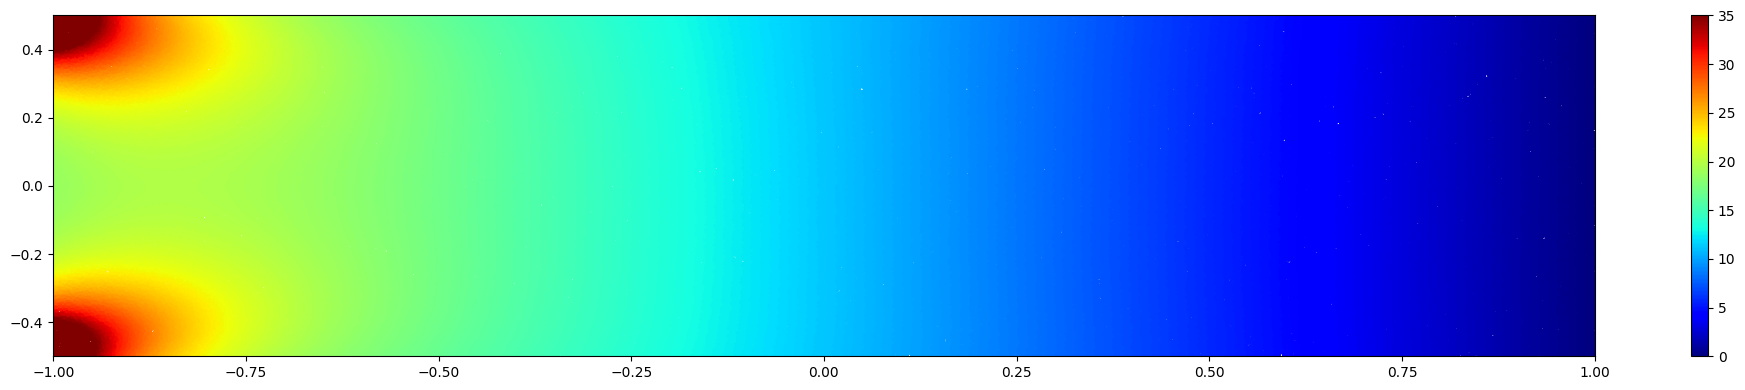

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20,4))
  plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap = 'jet', s = 2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()

#Validation

In [ ]:
#Analytical Solution
x = np.ones([1000, 1])
y = np.linspace(-D/2, D/2, 1000).reshape(1000, 1)
outlet = np.hstack([x, y])

analytical_solution = u_in * 1.5 * (1- ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

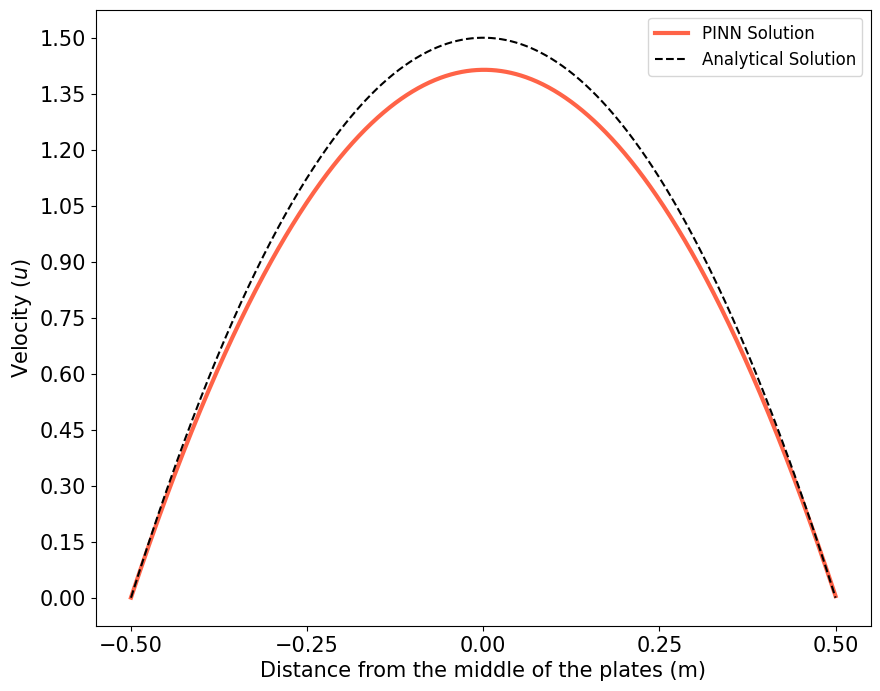

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:,0], c = 'tomato', linewidth = 3, label = 'PINN Solution')
plt.plot(y, analytical_solution, c = 'k', linestyle = '--', label = 'Analytical Solution')
plt.xticks(np.linspace(-D/2, D/2, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of the plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()

#ST Method

#Define Parameters

In [ ]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

#Boundary and Initial Conditions

In [ ]:
def boundary_wall(X, on_boundary):
  on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
  return on_wall

def boundary_inlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], L/2)

#Define PDE

In [ ]:
def pde(X, Y):
  u, v, p, sigma11, sigma22, sigma12 = Y[:, 0:1], Y[:, 1:2], Y[:, 2:3], Y[:, 3:4], Y[:, 4:5], Y[:, 5:6]

  du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
  du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
  dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
  dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)

  sigma11_x = dde.grad.jacobian(Y, X, i = 3, j = 0)
  sigma12_x = dde.grad.jacobian(Y, X, i = 5, j = 0)
  sigma12_y = dde.grad.jacobian(Y, X, i = 5, j = 1)
  sigma22_y = dde.grad.jacobian(Y, X, i = 4, j = 1)

  continuumx = rho * (u * du_x + v * du_y) - sigma11_x - sigma12_y
  continuumy = rho * (u * dv_x + v * dv_y) - sigma12_x - sigma22_y

  constitutive1 = - p + 2 * mu * du_x - sigma11
  constitutive2 = - p + 2 * mu * dv_y - sigma22
  constitutive3 = mu * (du_y + dv_x) - sigma12
  constitutive4 = p + (sigma11 + sigma22) / 2

  return continuumx, continuumy, constitutive1, constitutive2, constitutive3, constitutive4

#Define Geometry and Implement BC

In [ ]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

bcs = [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v]

In [ ]:
data = dde.data.PDE(geom, pde, bcs, num_domain = 2000, num_boundary = 200, num_test = 100)

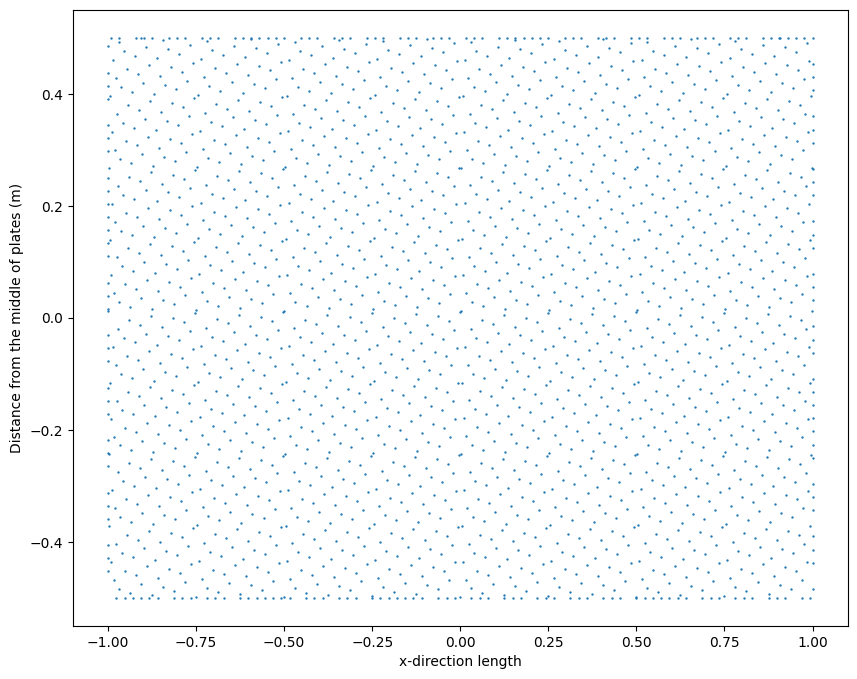

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

#Define Network and Hyper-Parameters

In [ ]:
layer_size = [2] + [64] * 6 + [6]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile('adam', lr = 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.092732 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.285920 s



#Train--ADAM Optimizer

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [7.72e-02, 1.81e-01, 4.79e-01, 5.83e-01, 5.95e-02, 5.53e-03, 4.65e-02, 3.66e-02, 1.78e+00, 1.06e-02, 6.39e-02, 1.10e-02]    [8.00e-02, 1.91e-01, 4.87e-01, 6.07e-01, 6.11e-02, 4.31e-03, 4.65e-02, 3.66e-02, 1.78e+00, 1.06e-02, 6.39e-02, 1.10e-02]    []  
1000      [4.03e-04, 2.82e-04, 3.50e-03, 4.56e-03, 1.17e-03, 1.30e-02, 3.57e-02, 1.65e-02, 3.83e-02, 5.52e-03, 1.12e-05, 1.17e-05]    [2.67e-04, 1.90e-04, 2.24e-03, 2.41e-03, 8.88e-04, 8.43e-03, 3.57e-02, 1.65e-02, 3.83e-02, 5.52e-03, 1.12e-05, 1.17e-05]    []  
2000      [4.82e-04, 3.37e-04, 2.83e-03, 2.48e-03, 1.02e-03, 7.70e-03, 2.64e-02, 1.32e-02, 3.93e-02, 1.73e-03, 3.15e-05, 1.12e-05]    [2.84e-04, 2.36e-04, 1.58e-03, 1.26e-03, 5.36e-04, 

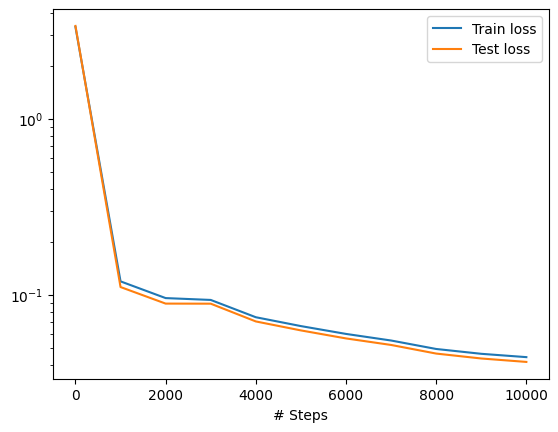

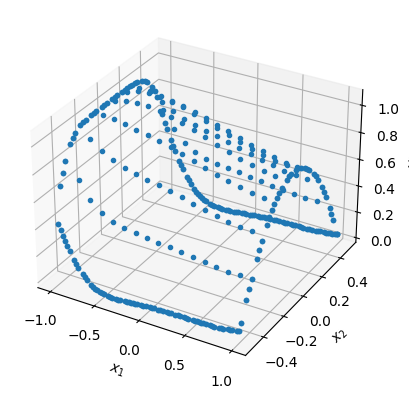

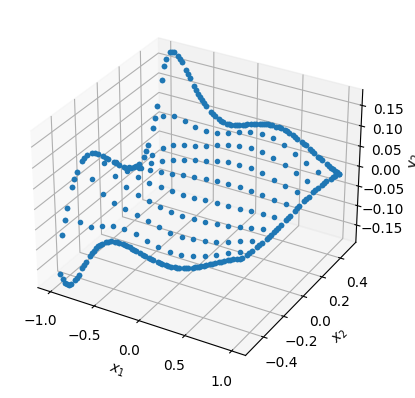

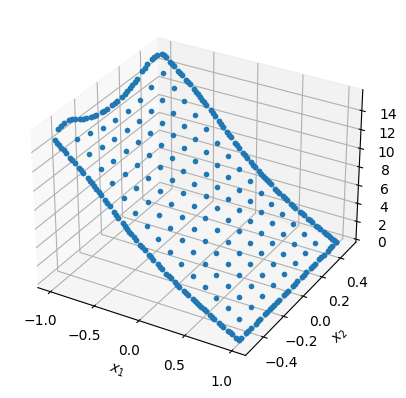

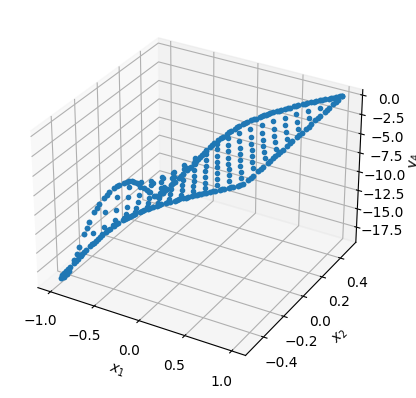

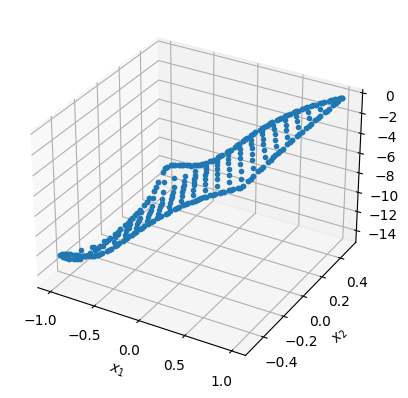

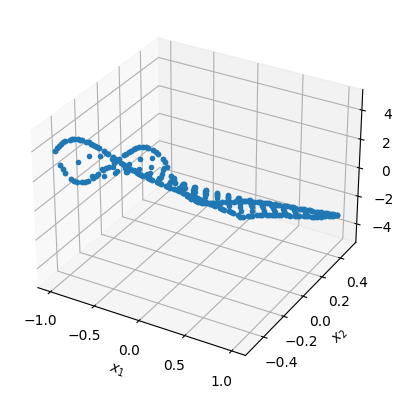

In [ ]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM Optimizer

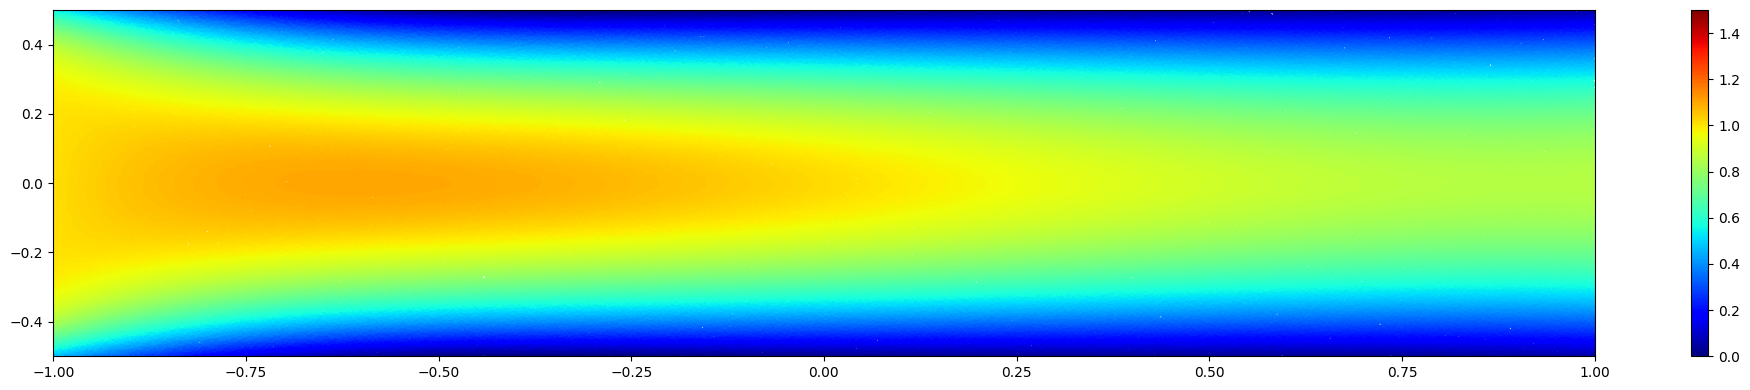

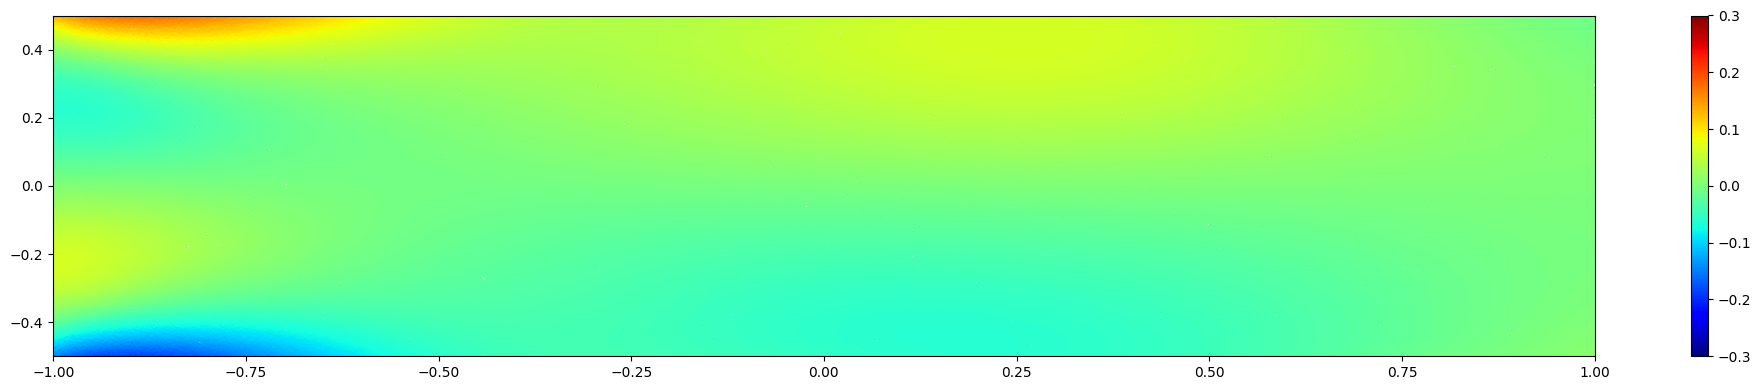

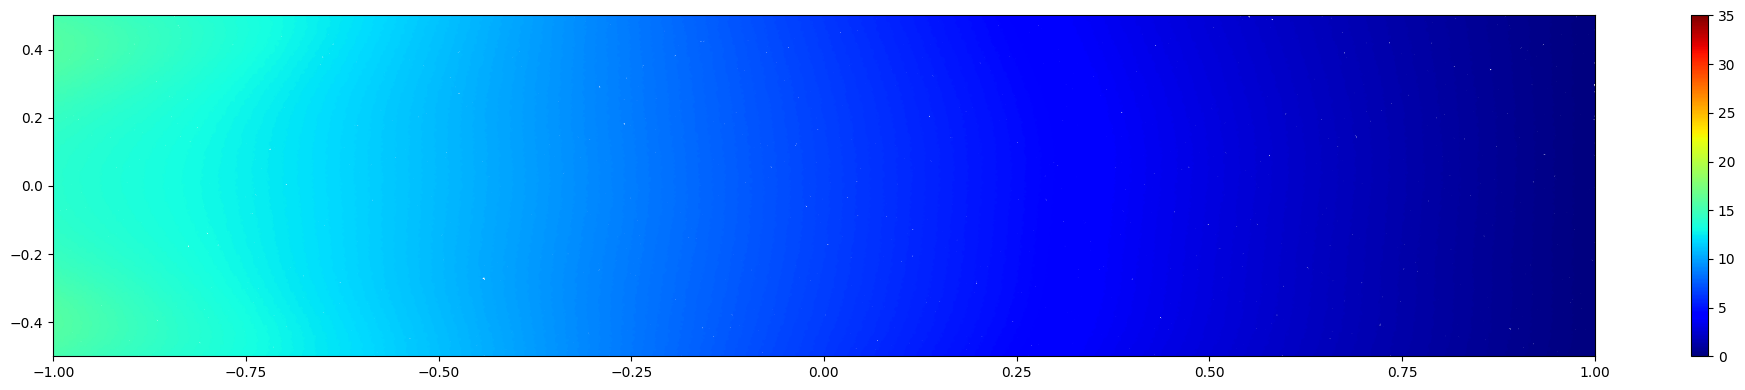

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20, 4))
  plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap = 'jet', s = 2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()

#Train More--L-BFGS Optimizer

Compiling model...
'compile' took 0.951885 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
10000     [3.44e-04, 2.03e-04, 8.62e-04, 1.02e-03, 5.03e-04, 2.39e-03, 1.52e-02, 6.54e-03, 1.47e-02, 2.30e-03, 5.53e-05, 1.58e-05]    [2.75e-04, 1.27e-04, 5.32e-04, 2.99e-04, 2.02e-04, 1.21e-03, 1.52e-02, 6.54e-03, 1.47e-02, 2.30e-03, 5.53e-05, 1.58e-05]    []  
11000     [3.40e-04, 3.05e-04, 4.36e-04, 1.03e-03, 4.90e-04, 1.51e-03, 8.09e-03, 1.42e-03, 7.46e-03, 4.94e-03, 1.20e-05, 1.01e-06]    [3.40e-04, 3.05e-04, 4.36e-04, 1.03e-03, 4.90e-04, 1.51e-03, 8.09e-03, 1.42e-03, 7.46e-03, 4.94e-03, 1.20e-05, 1.01e-06]        
12000     [4.52e-04, 4.28e-04, 4.96e-04, 6.57e-04, 4.29e-04, 4.86e-04, 5.89e-03, 8.64e-04, 4.92e-03, 2.23e-03, 5.45e-06, 4.99e-06]    [4.52

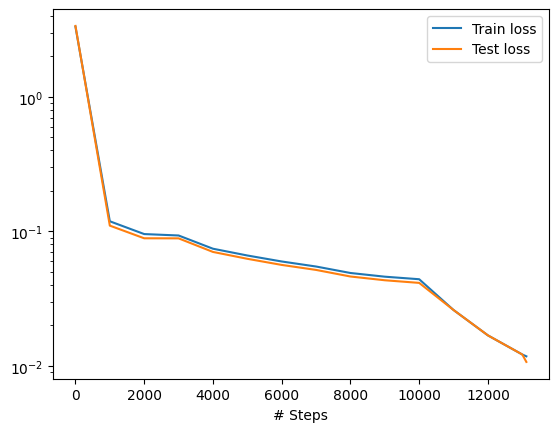

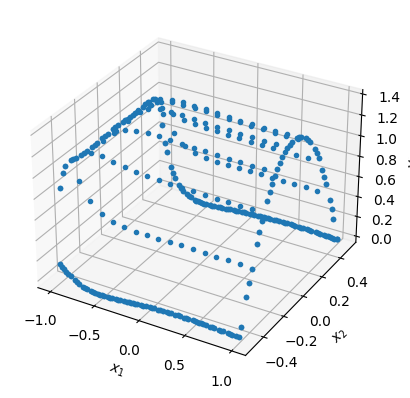

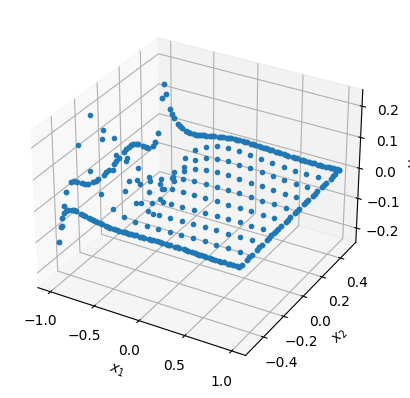

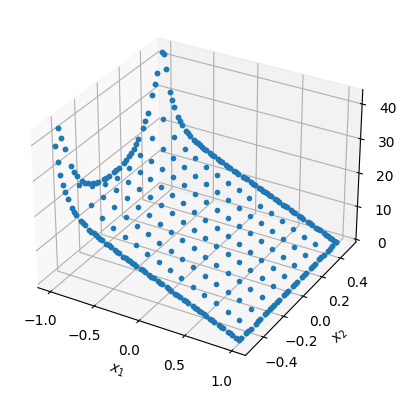

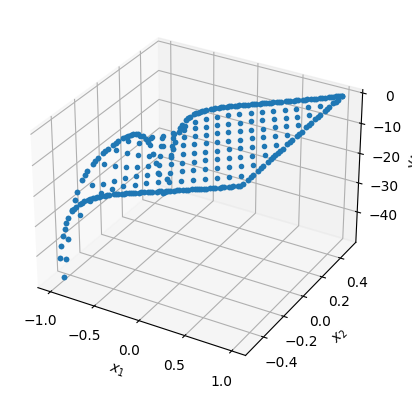

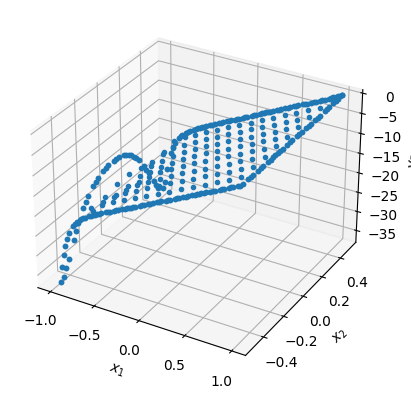

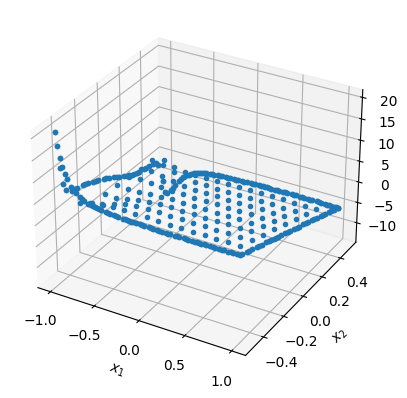

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)

model.compile('L-BFGS')
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM + L-BFGS

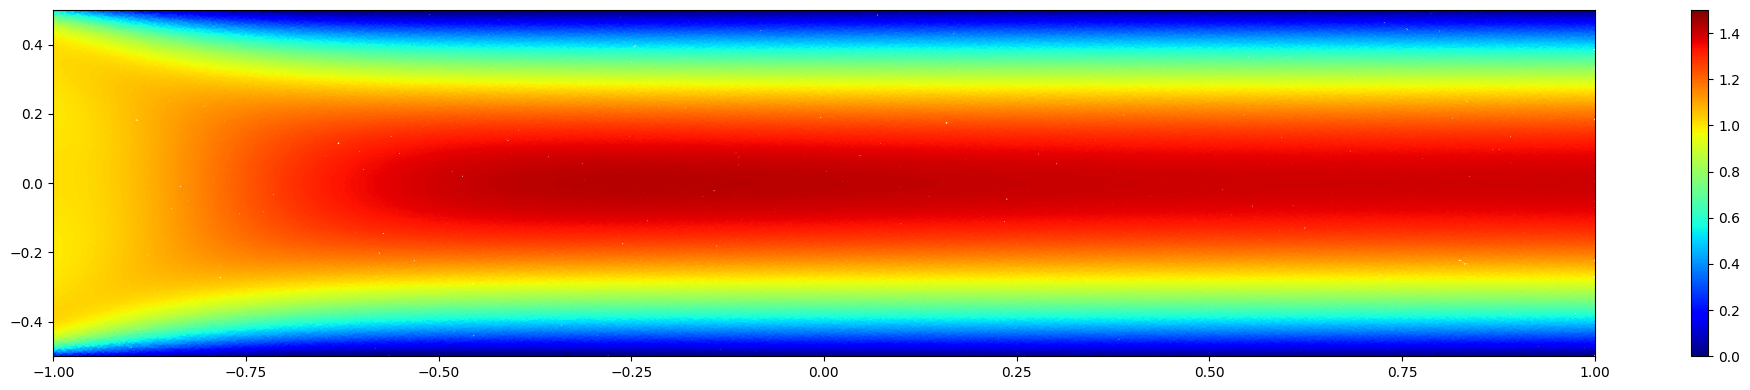

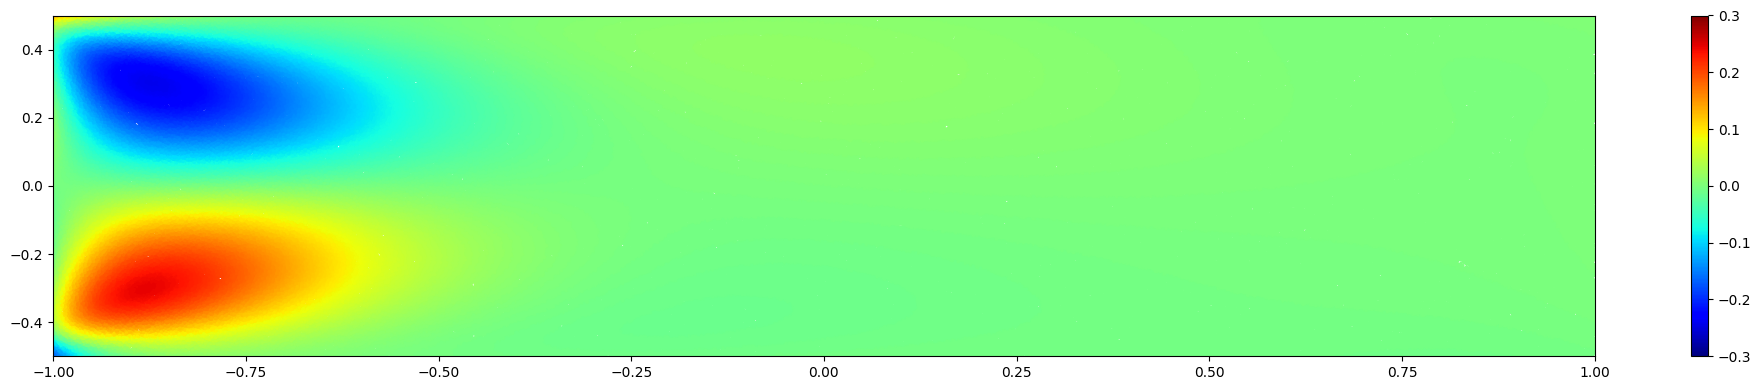

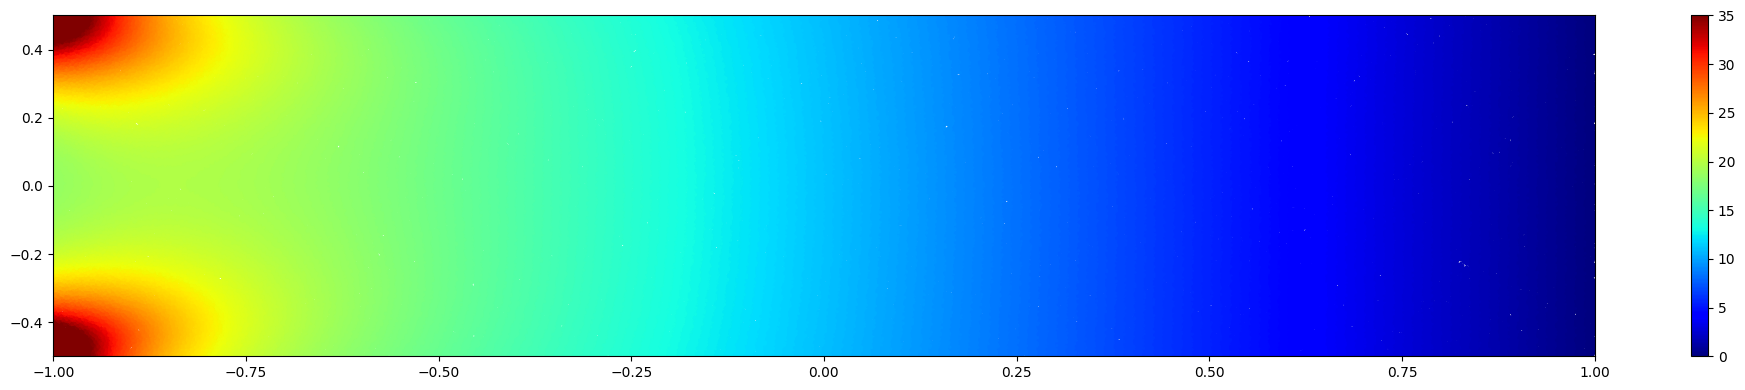

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20, 4))
  plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap = 'jet', s = 2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()

#Validation

In [ ]:
#Analytical Solution
x = np.ones([1000, 1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000, 1)
outlet = np.hstack([x, y])

analytical_solution = u_in * 1.5 * (1- ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

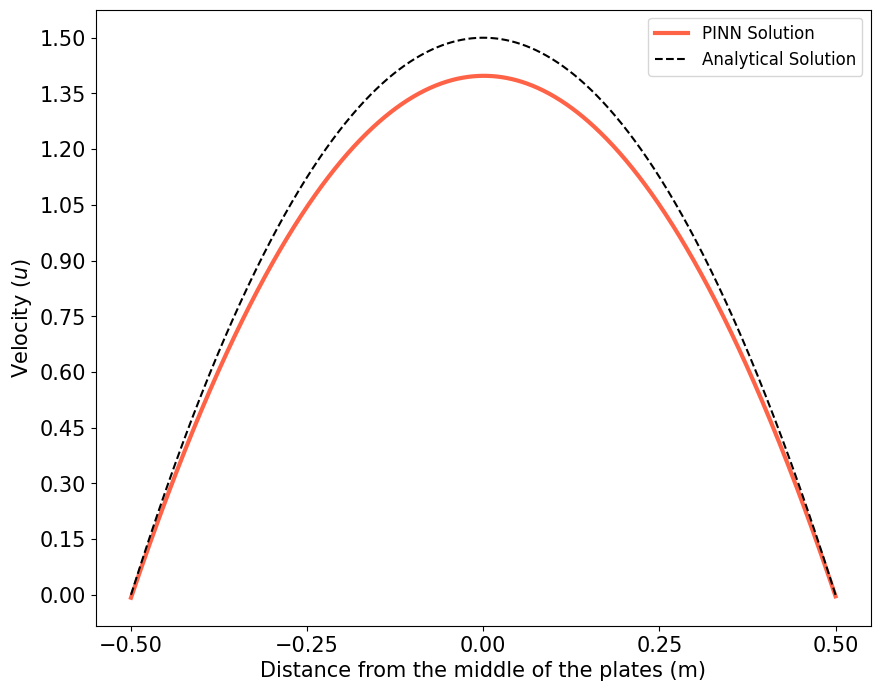

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:,0], c = 'tomato', linewidth = 3, label = 'PINN Solution')
plt.plot(y, analytical_solution, c = 'k', linestyle = '--', label = 'Analytical Solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of the plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()

#VP Method with NACA

#Define Parameters

In [ ]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

#Boundary and Initial Conditions

In [ ]:
def boundary_wall(X, on_boundary):
  on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
  return on_wall

def boundary_inlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], L/2)

def boundary_naca(X, on_boundary):
    return on_boundary and (not farfieldgeom.on_boundary(X))

#Define PDE

In [ ]:
def pde(x, y):
  psi, p = y[:, 0:1], y[:, 1:2]

  u = dde.grad.jacobian(y, x, i = 0, j = 1)
  v = - dde.grad.jacobian(y, x, i = 0, j = 0)

  du_x = dde.grad.jacobian(u, x, i = 0, j = 0)
  du_y = dde.grad.jacobian(u, x, i = 0, j = 1)
  dv_x = dde.grad.jacobian(v, x, i = 0, j = 0)
  dv_y = dde.grad.jacobian(v, x, i = 0, j = 1)
  dp_x = dde.grad.jacobian(y, x, i = 1, j = 0)
  dp_y = dde.grad.jacobian(y, x, i = 1, j = 1)
  du_xx = dde.grad.hessian(u, x, i = 0, j = 0, component = 0)
  du_yy = dde.grad.hessian(u, x, i = 0, j = 1, component = 0)
  dv_xx = dde.grad.hessian(v, x, i = 0, j = 0, component = 0)
  dv_yy = dde.grad.hessian(v, x, i = 0, j = 1, component = 0)

  pde_u = u*du_x + v*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
  pde_v = u*dv_x + v*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
  pde_cont = du_x + dv_y

  return [pde_u, pde_v, pde_cont]

#Define Geometry and Implement BC

In [ ]:
farfieldgeom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

import pandas as pd
nacadata = pd.read_excel('NACA 3414 Geometry.xlsx')
#nacadata = pd.read_excel('C://users/conno/OneDrive/Documents/School/College/Fourth Year/Spring 2024/Aero 689/HW3 Resources/NACA 3414 Geometry.xlsx')
xnaca = [nacadata['X NACA 3414']/2-L/4]
ynaca = [nacadata['Y NACA 3414']/2]
rotated = np.dot(np.matrix([[np.cos(np.radians(5)), np.sin(np.radians(5))], [-1*np.sin(np.radians(5)), np.cos(np.radians(5))]]), [xnaca[0], ynaca[0]])
xnacarotate = list(np.asarray(rotated.T[:, 0]).reshape(-1))
ynacarotate = list(np.asarray(rotated.T[:, 1]).reshape(-1))
nacaxy = np.vstack((xnacarotate,ynacarotate)).T
nacageom = dde.geometry.Polygon(nacaxy)

geom = dde.geometry.CSGDifference(farfieldgeom, nacageom)

inner_rec  = dde.geometry.Rectangle([-0.65, -0.15], [-0.35, 0.15])
outer_dom  = dde.geometry.CSGDifference(farfieldgeom, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, nacageom)
inner_dom  = dde.geometry.CSGDifference(inner_rec, nacageom)

inner_points = inner_dom.random_points(1000)
outer_points = outer_dom.random_points(2000)

farfield_points = farfieldgeom.random_boundary_points(200)
airfoil_points  = nacaxy

points = np.append(inner_points, outer_points, axis = 0)
points = np.append(points, farfield_points, axis = 0)
points = np.append(points, airfoil_points, axis = 0)

# Boundary values definition
def fun_u_farfield(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1) - 1.0

def fun_no_slip_u(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def fun_no_slip_v(x, y, _):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def funP(x):
    return 0.0

# Boundary conditions assembly
bc_inlet_u = dde.OperatorBC(geom, fun_u_farfield, boundary_inlet)
bc_inlet_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_inlet)

bc_top_bottom_u = dde.OperatorBC(geom, fun_u_farfield, boundary_wall)
bc_top_bottom_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_wall)

bc_outlet_p = dde.DirichletBC(geom, funP, boundary_outlet, component = 1)
bc_outlet_u = dde.OperatorBC(geom, fun_u_farfield, boundary_outlet)

bc_airfoil_u = dde.OperatorBC(geom, fun_no_slip_u, boundary_naca)
bc_airfoil_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_naca)

bcs = [bc_inlet_u, bc_inlet_v, bc_top_bottom_u, bc_top_bottom_v, bc_outlet_p, bc_outlet_u, bc_airfoil_u, bc_airfoil_v]

In [ ]:
data = dde.data.PDE(geom, pde, bcs, num_domain = 0, num_boundary = 0, num_test = 100, anchors = points)

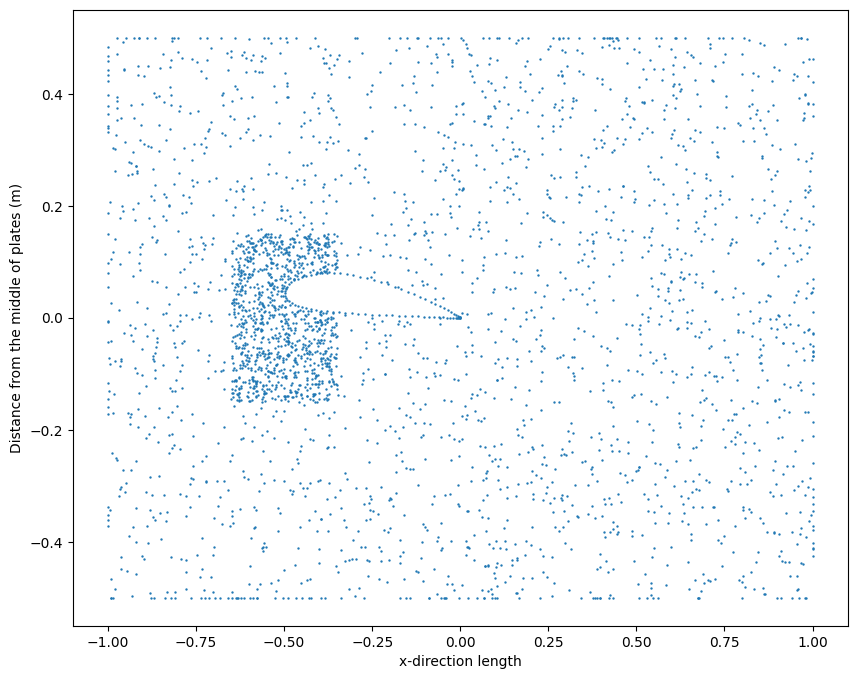

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

#Define Network and Hyper-Parameters

In [ ]:
layer_size = [2] + [64] * 6 + [4]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile('adam', lr = 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.118770 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 12.910238 s



#Train--ADAM Optimizer

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [1.16e-01, 3.38e-02, 1.18e-16, 8.13e-01, 2.75e-03, 8.00e-01, 5.27e-03, 1.14e-01, 8.10e-01, 1.59e-02, 6.21e-03]    [1.10e-01, 3.25e-02, 1.67e-16, 8.13e-01, 2.75e-03, 8.00e-01, 5.27e-03, 1.14e-01, 8.10e-01, 1.59e-02, 6.21e-03]    []  
1000      [5.80e-03, 3.92e-03, 6.18e-14, 2.44e-02, 9.74e-03, 1.98e-02, 5.65e-02, 1.20e-03, 3.16e-02, 3.94e-02, 1.11e-03]    [9.16e-03, 1.72e-03, 5.52e-14, 2.44e-02, 9.74e-03, 1.98e-02, 5.65e-02, 1.20e-03, 3.16e-02, 3.94e-02, 1.11e-03]    []  
2000      [6.96e-03, 5.04e-03, 9.07e-14, 2.02e-02, 8.39e-03, 1.20e-02, 3.88e-02, 4.88e-04, 1.44e-02, 1.45e-02, 7.04e-04]    [1.18e-02, 6.40e-03, 1.09e-13, 2.02e-02, 8.39e-03, 1.20e-02, 3.88e-02, 4.88e-04, 1.44e-02, 1.45e-02, 7.04e-04]    []  
30

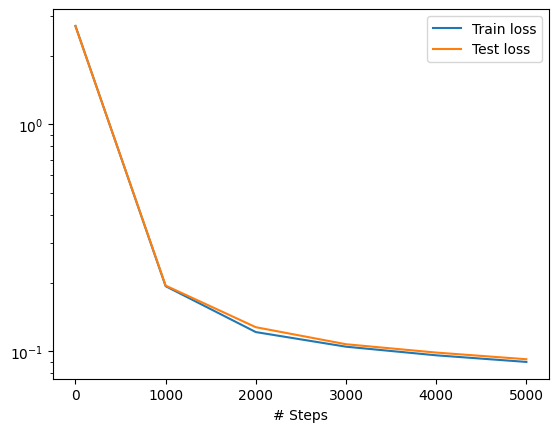

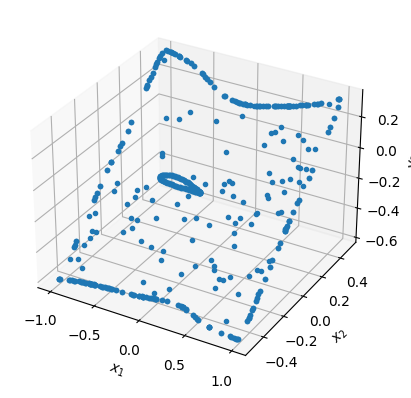

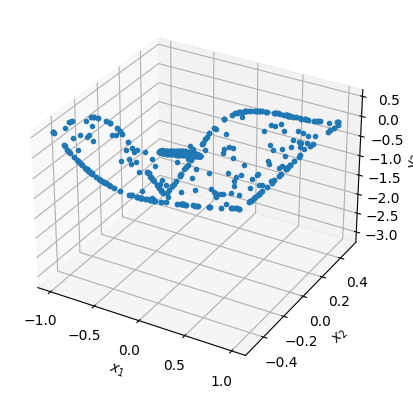

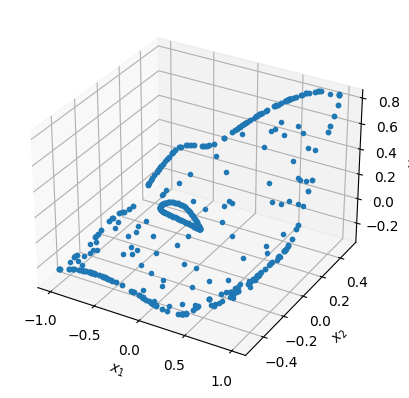

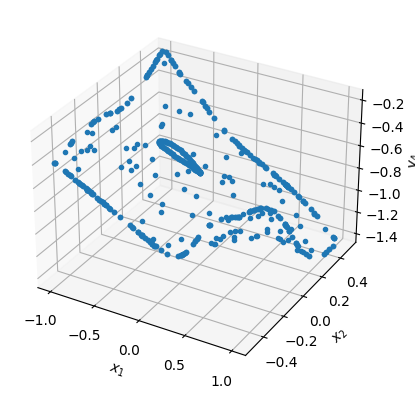

In [ ]:
losshistory, train_state = model.train(epochs = 5000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM Optimizer

<ipython-input-12-65460e15e715>:40: UserWarning: The following kwargs were not used by contour: 's'
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)


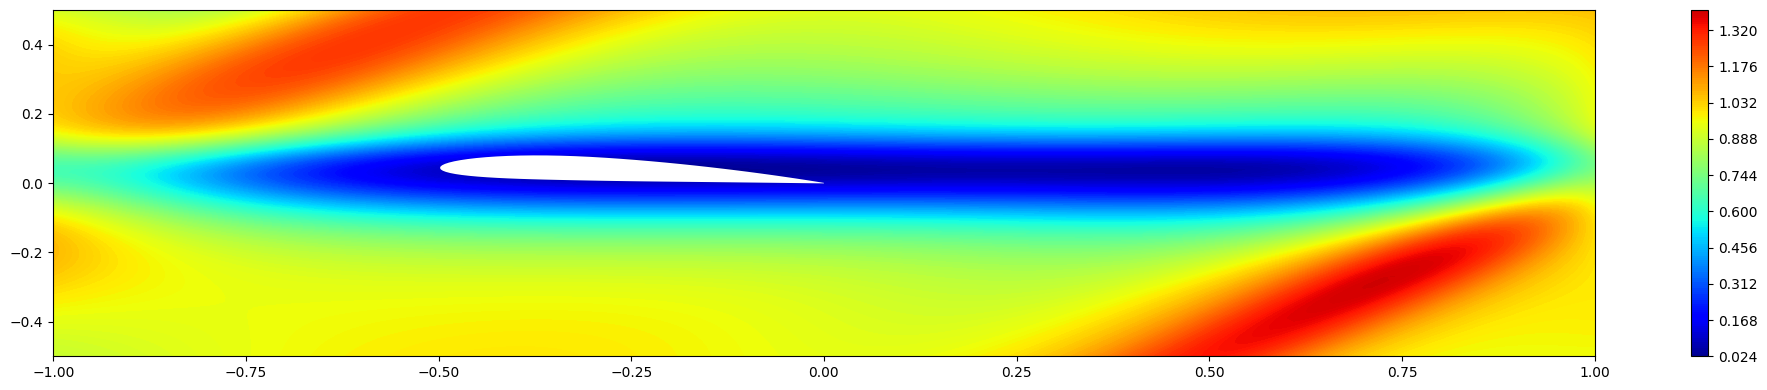

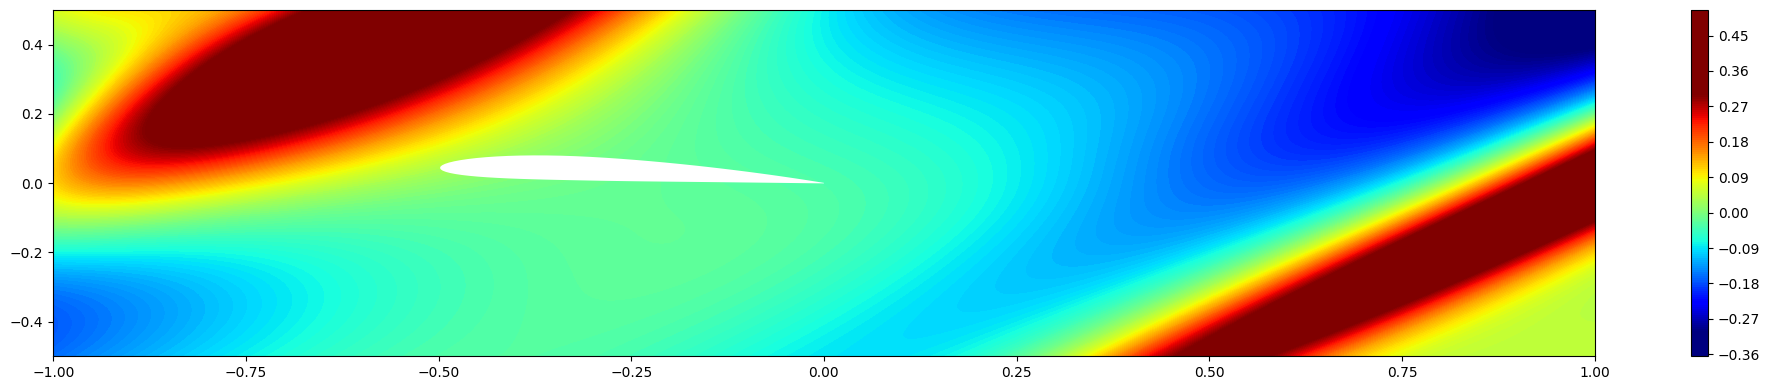

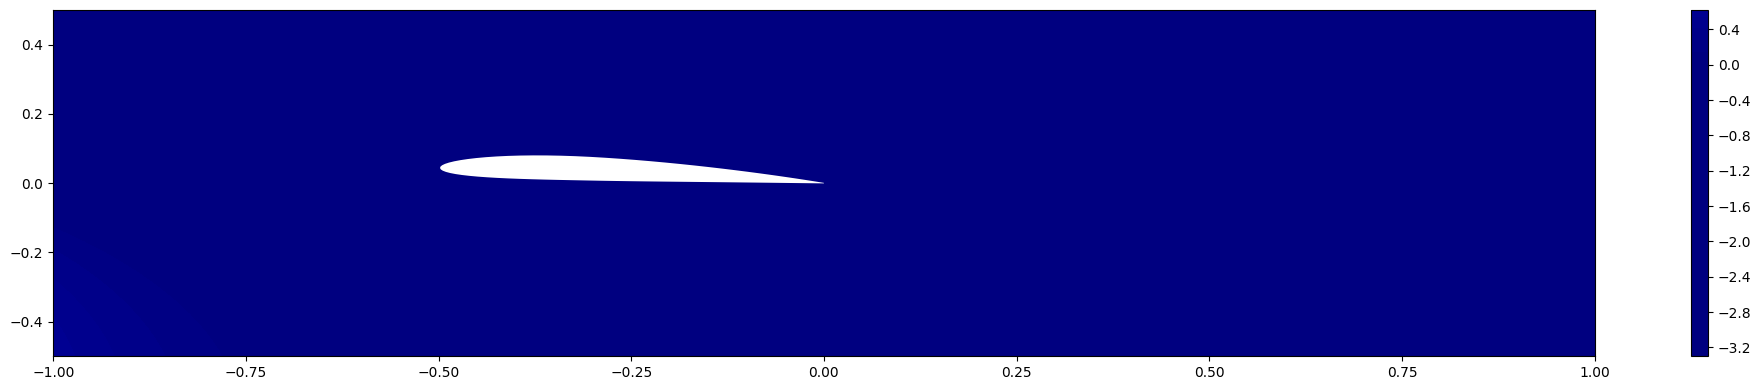

In [ ]:
dx = 0.01
dy = 0.01
x = np.arange(-L/2, L/2 + dx, dx)
y = np.arange(-D/2, D/2 + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

def getU(x, y):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def getV(x, y):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def getP(x, y):
    return y[:, 1:2]

# Model predictions generation
u = model.predict(X, operator = getU)
v = model.predict(X, operator = getV)
p = model.predict(X, operator = getP)

#for i in range(len(X)):
#    if airfoil.inside(np.array([X[i]]))[0]:
#        u[i] = 0.0
#        v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

result = [u, v, p]

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20, 4))
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)
  plt.fill_between(xnacarotate, ynacarotate, facecolor = 'w')
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()

#Train More--L-BFGS Optimizer

Compiling model...
'compile' took 4.152503 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
5000      [4.07e-03, 3.56e-03, 9.16e-14, 1.72e-02, 5.87e-03, 1.08e-02, 3.08e-02, 4.90e-04, 7.25e-03, 8.93e-03, 7.12e-04]    [7.15e-03, 2.96e-03, 1.56e-13, 1.72e-02, 5.87e-03, 1.08e-02, 3.08e-02, 4.90e-04, 7.25e-03, 8.93e-03, 7.12e-04]    []  
6000      [1.74e-03, 1.58e-03, 2.37e-13, 1.63e-02, 3.49e-03, 7.76e-03, 2.19e-02, 1.81e-04, 3.53e-03, 8.87e-03, 5.51e-04]    [1.74e-03, 1.58e-03, 2.37e-13, 1.63e-02, 3.49e-03, 7.76e-03, 2.19e-02, 1.81e-04, 3.53e-03, 8.87e-03, 5.51e-04]        
7000      [1.64e-03, 1.10e-03, 4.26e-13, 1.45e-02, 3.31e-03, 7.12e-03, 2.09e-02, 1.05e-04, 3.03e-03, 8.42e-03, 6.91e-04]    [1.64e-03, 1.10e-03, 4.26e-13, 1.45e-02, 3.31e-03, 7.12e-03, 2.09e-02, 1.05

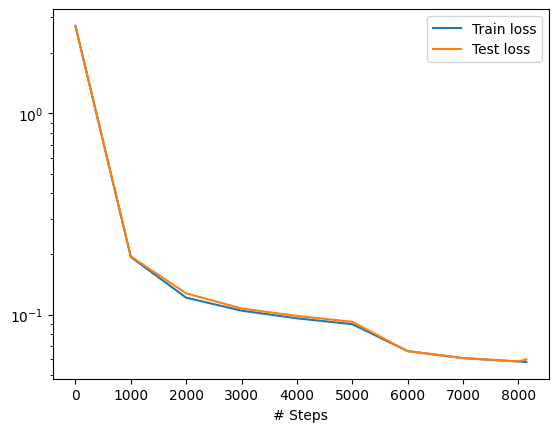

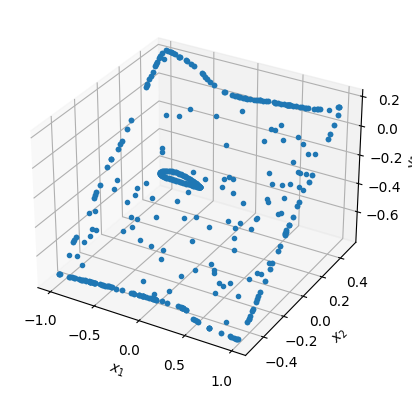

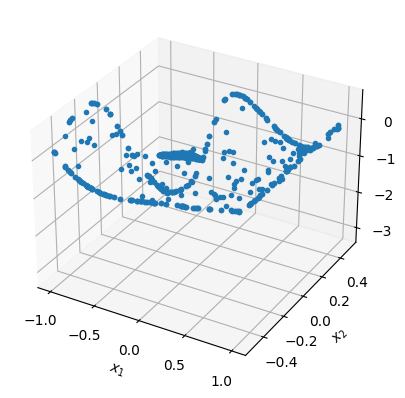

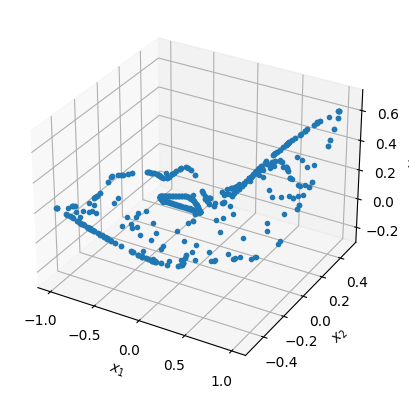

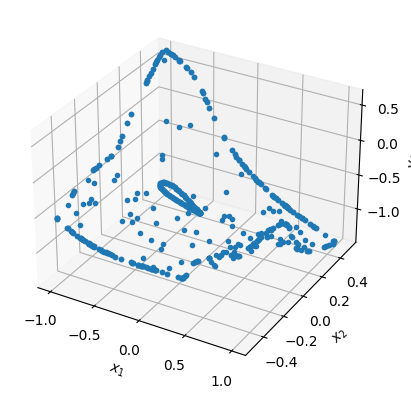

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)

model.compile('L-BFGS')
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM + L-BFGS

<ipython-input-14-65460e15e715>:40: UserWarning: The following kwargs were not used by contour: 's'
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)


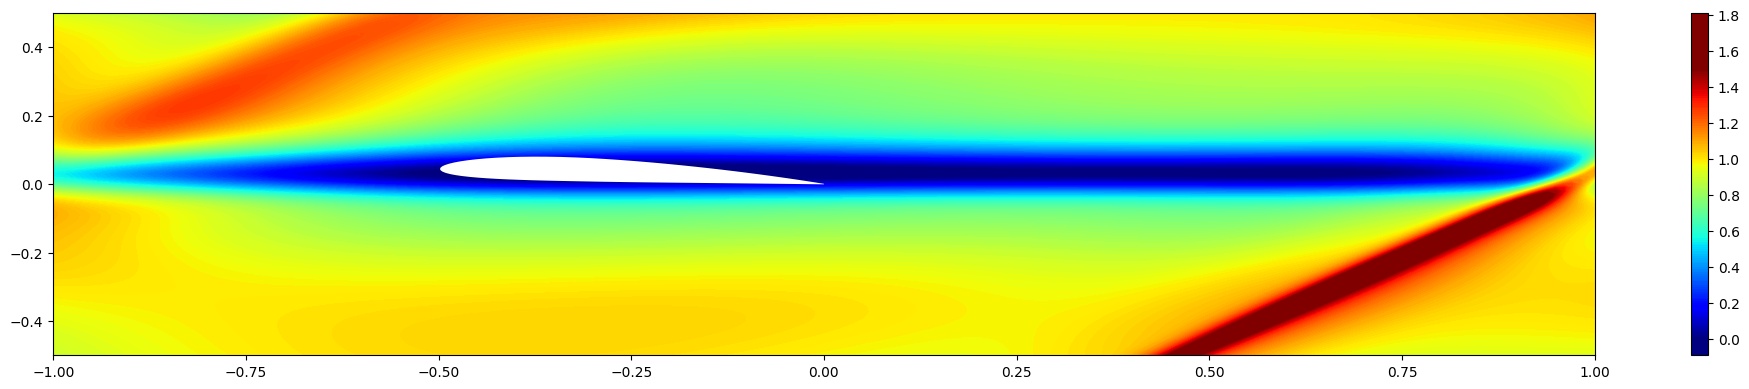

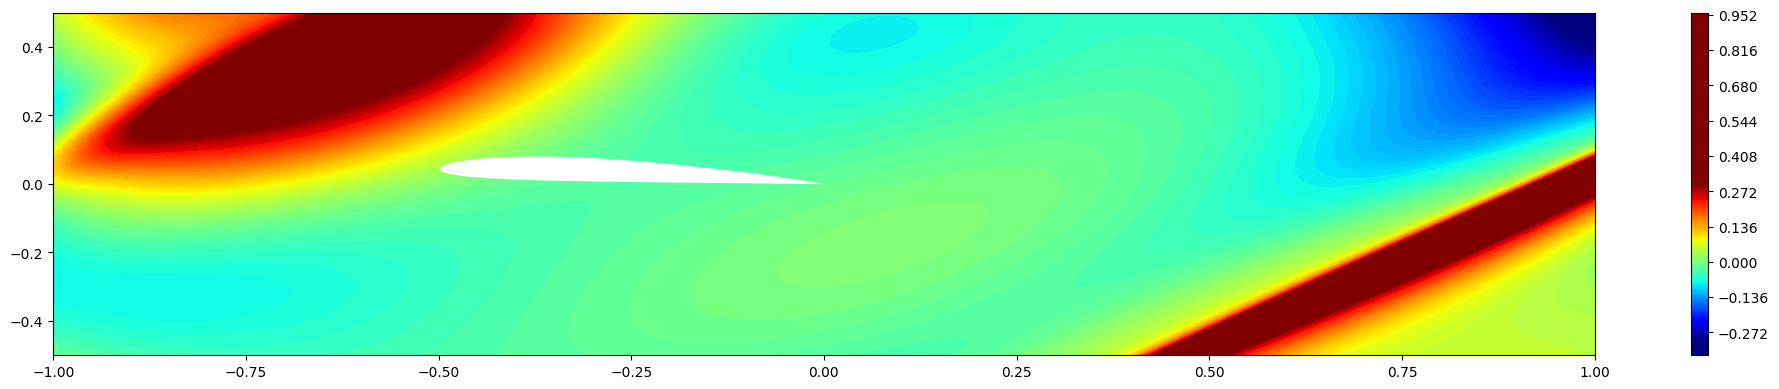

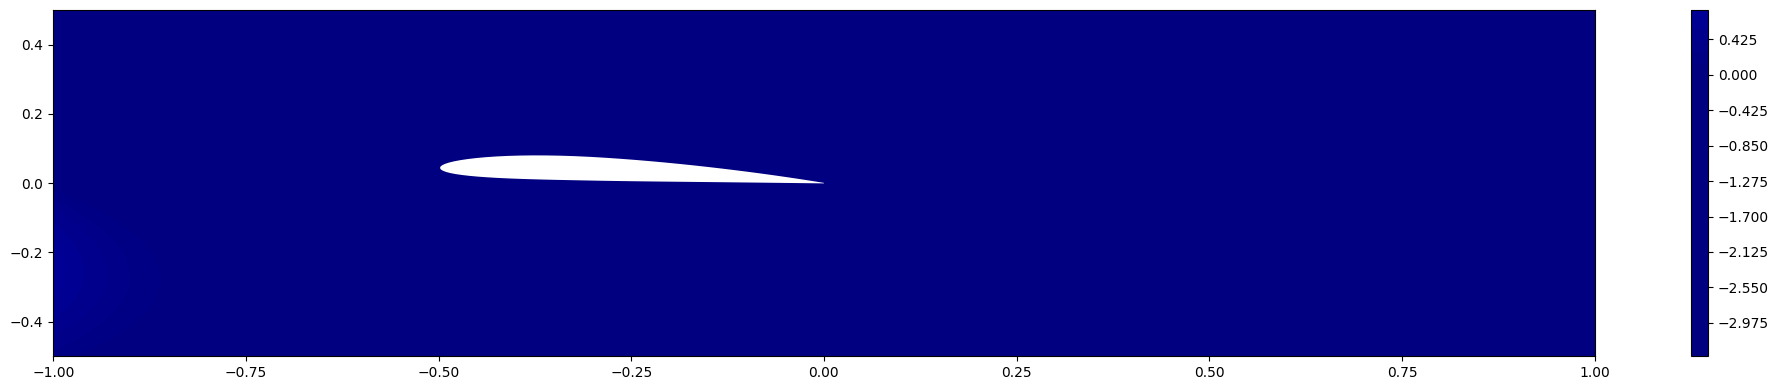

In [ ]:
dx = 0.01
dy = 0.01
x = np.arange(-L/2, L/2 + dx, dx)
y = np.arange(-D/2, D/2 + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

def getU(x, y):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def getV(x, y):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def getP(x, y):
    return y[:, 1:2]

# Model predictions generation
u = model.predict(X, operator = getU)
v = model.predict(X, operator = getV)
p = model.predict(X, operator = getP)

#for i in range(len(X)):
#    if airfoil.inside(np.array([X[i]]))[0]:
#        u[i] = 0.0
#        v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

result = [u, v, p]

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20, 4))
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)
  plt.fill_between(xnacarotate, ynacarotate, facecolor = 'w')
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()

#ST Method with NACA

#Define Parameters

In [ ]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

#Boundary and Initial Conditions

In [ ]:
def boundary_wall(X, on_boundary):
  on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
  return on_wall

def boundary_inlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
  return on_boundary and np.isclose(X[0], L/2)

def boundary_naca(X, on_boundary):
    return on_boundary and (not farfieldgeom.on_boundary(X))

#Define PDE

In [ ]:
def pde(x, y):
    psi, p, sigma11, sigma22, sigma12 = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4], y[:, 4:5]

    u =   dde.grad.jacobian(y, x, i = 0, j = 1)
    v = - dde.grad.jacobian(y, x, i = 0, j = 0)

    u_x = dde.grad.jacobian(u, x, i = 0, j = 0)
    u_y = dde.grad.jacobian(u, x, i = 0, j = 1)

    v_x = dde.grad.jacobian(v, x, i = 0, j = 0)
    v_y = dde.grad.jacobian(v, x, i = 0, j = 1)

    sigma11_x = dde.grad.jacobian(y, x, i = 2, j = 0)
    sigma12_x = dde.grad.jacobian(y, x, i = 4, j = 0)
    sigma12_y = dde.grad.jacobian(y, x, i = 4, j = 1)
    sigma22_y = dde.grad.jacobian(y, x, i = 3, j = 1)

    continuumx = rho * (u * u_x + v * u_y) - sigma11_x - sigma12_y
    continuumy = rho * (u * v_x + v * v_y) - sigma12_x - sigma22_y

    constitutive1 = - p + 2 * mu * u_x - sigma11
    constitutive2 = - p + 2 * mu * v_y - sigma22
    constitutive3 = mu * (u_y + v_x) - sigma12
    constitutive4 = p + (sigma11 + sigma22) / 2

    return continuumx, continuumy, constitutive1, constitutive2, constitutive3, constitutive4

#Define Geometry and Implement BC

In [ ]:
farfieldgeom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

import pandas as pd
nacadata = pd.read_excel('NACA 3414 Geometry.xlsx')
#nacadata = pd.read_excel('C://users/conno/OneDrive/Documents/School/College/Fourth Year/Spring 2024/Aero 689/HW3 Resources/NACA 3414 Geometry.xlsx')
xnaca = [nacadata['X NACA 3414']/2-L/4]
ynaca = [nacadata['Y NACA 3414']/2]
rotated = np.dot(np.matrix([[np.cos(np.radians(5)), np.sin(np.radians(5))], [-1*np.sin(np.radians(5)), np.cos(np.radians(5))]]), [xnaca[0], ynaca[0]])
xnacarotate = list(np.asarray(rotated.T[:, 0]).reshape(-1))
ynacarotate = list(np.asarray(rotated.T[:, 1]).reshape(-1))
nacaxy = np.vstack((xnacarotate,ynacarotate)).T
nacageom = dde.geometry.Polygon(nacaxy)

geom = dde.geometry.CSGDifference(farfieldgeom, nacageom)

inner_rec  = dde.geometry.Rectangle([-0.65, -0.15], [-0.35, 0.15])
outer_dom  = dde.geometry.CSGDifference(farfieldgeom, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, nacageom)
inner_dom  = dde.geometry.CSGDifference(inner_rec, nacageom)

inner_points = inner_dom.random_points(1000)
outer_points = outer_dom.random_points(2000)

farfield_points = farfieldgeom.random_boundary_points(200)
airfoil_points  = nacaxy

points = np.append(inner_points, outer_points, axis = 0)
points = np.append(points, farfield_points, axis = 0)
points = np.append(points, airfoil_points, axis = 0)

# Boundary values definition
def fun_u_farfield(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1) - 1.0

def fun_no_slip_u(x, y, _):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def fun_no_slip_v(x, y, _):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def funP(x):
    return 0.0

# Boundary conditions assembly
bc_inlet_u = dde.OperatorBC(geom, fun_u_farfield, boundary_inlet)
bc_inlet_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_inlet)

bc_top_bottom_u = dde.OperatorBC(geom, fun_u_farfield, boundary_wall)
bc_top_bottom_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_wall)

bc_outlet_p = dde.DirichletBC(geom, funP, boundary_outlet, component = 1)
bc_outlet_u = dde.OperatorBC(geom, fun_u_farfield, boundary_outlet)

bc_airfoil_u = dde.OperatorBC(geom, fun_no_slip_u, boundary_naca)
bc_airfoil_v = dde.OperatorBC(geom, fun_no_slip_v, boundary_naca)

bcs = [bc_inlet_u, bc_inlet_v, bc_top_bottom_u, bc_top_bottom_v, bc_outlet_p, bc_outlet_u, bc_airfoil_u, bc_airfoil_v]

In [ ]:
data = dde.data.PDE(geom, pde, bcs, num_domain = 0, num_boundary = 0, num_test = 100, anchors = points)

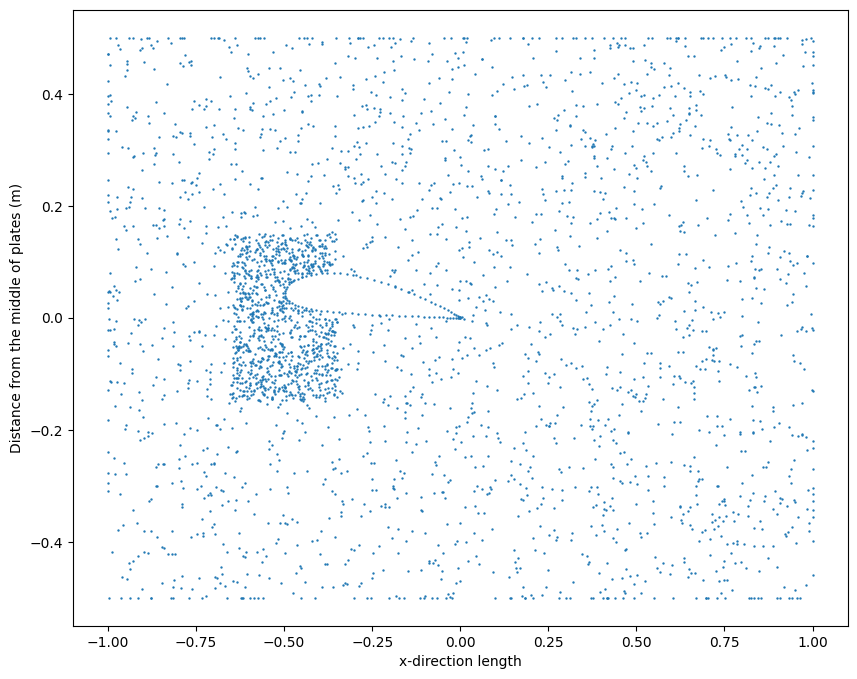

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

#Define Network and Hyper-Parameters

In [ ]:
layer_size = [2] + [64] * 6 + [5]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile('adam', lr = 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.102549 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.960881 s



#Train--ADAM Optimizer

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
0         [1.81e-03, 8.28e-04, 1.60e-02, 1.89e-02, 4.41e-05, 3.79e-05, 8.96e-01, 4.39e-04, 8.88e-01, 5.97e-04, 5.52e-04, 9.03e-01, 5.74e-03, 6.82e-04]    [2.15e-03, 9.28e-04, 1.43e-02, 1.69e-02, 4.84e-05, 3.85e-05, 8.96e-01, 4.39e-04, 8.88e-01, 5.97e-04, 5.52e-04, 9.03e-01, 5.74e-03, 6.82e-04]    []  
1000      [1.77e-03, 1.38e-03, 3.95e-03, 8.38e-03, 7.44e-03, 4.04e-04, 4.42e-02, 1.53e-02, 8.16e-03, 5.36e-02, 5.70e-04, 1.62e-02, 7.15e-02, 1.57e-04]    [1.94e-03, 1.04e-03, 4.00e-03, 8.27e-03, 9.86e-03, 3.81e-04, 4.42e-02, 1.53e-02, 8.16e-03, 5.36e-02, 5.70e-04, 1.62e-02, 7.15e-02, 1.57e-04]    []  
2000      [2.48e-03, 4.91e-03, 7.05e-03, 7.30e-03, 5.23e-03, 2.93

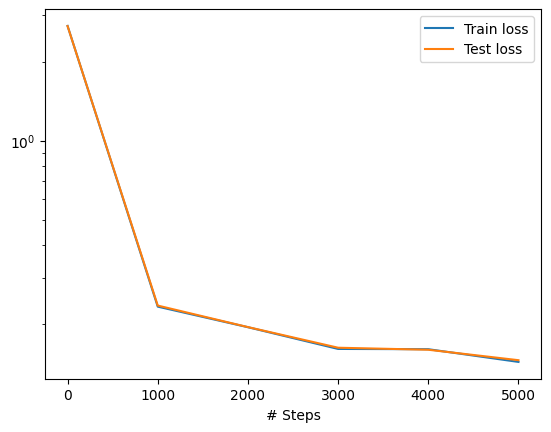

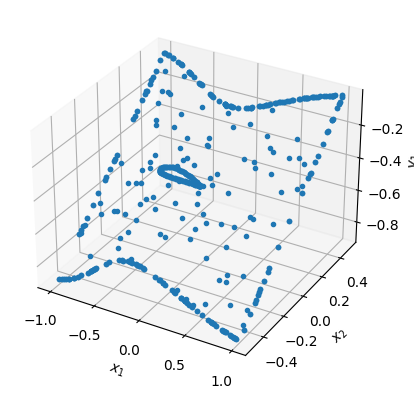

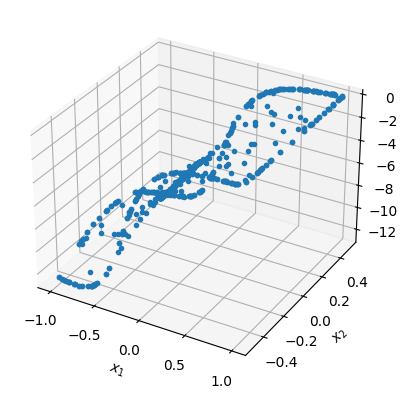

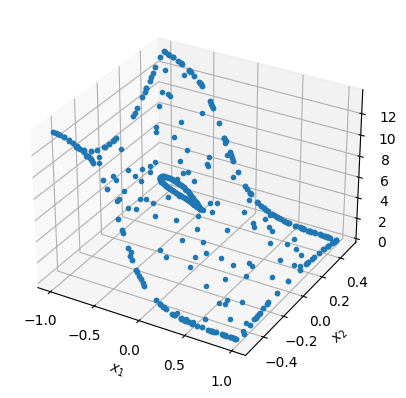

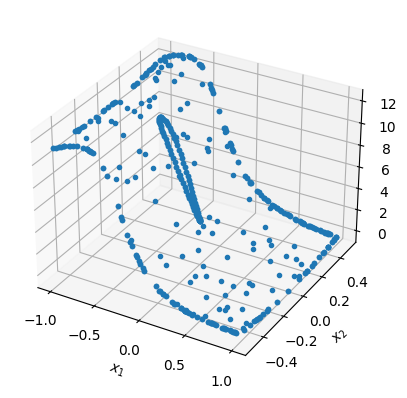

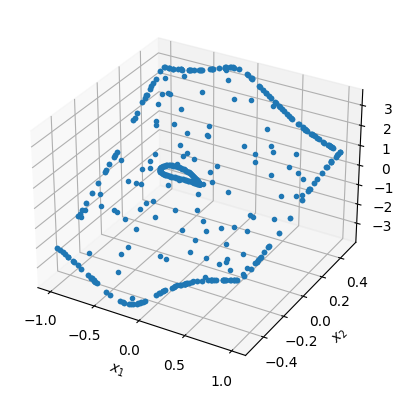

In [ ]:
losshistory, train_state = model.train(epochs = 5000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM Optimizer

<ipython-input-25-65460e15e715>:40: UserWarning: The following kwargs were not used by contour: 's'
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)


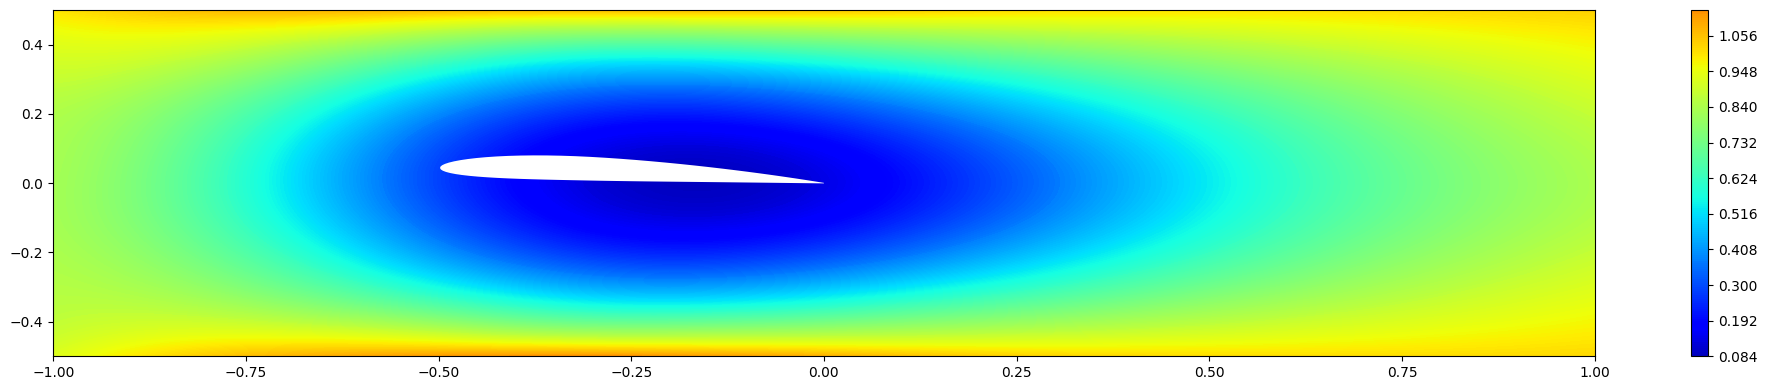

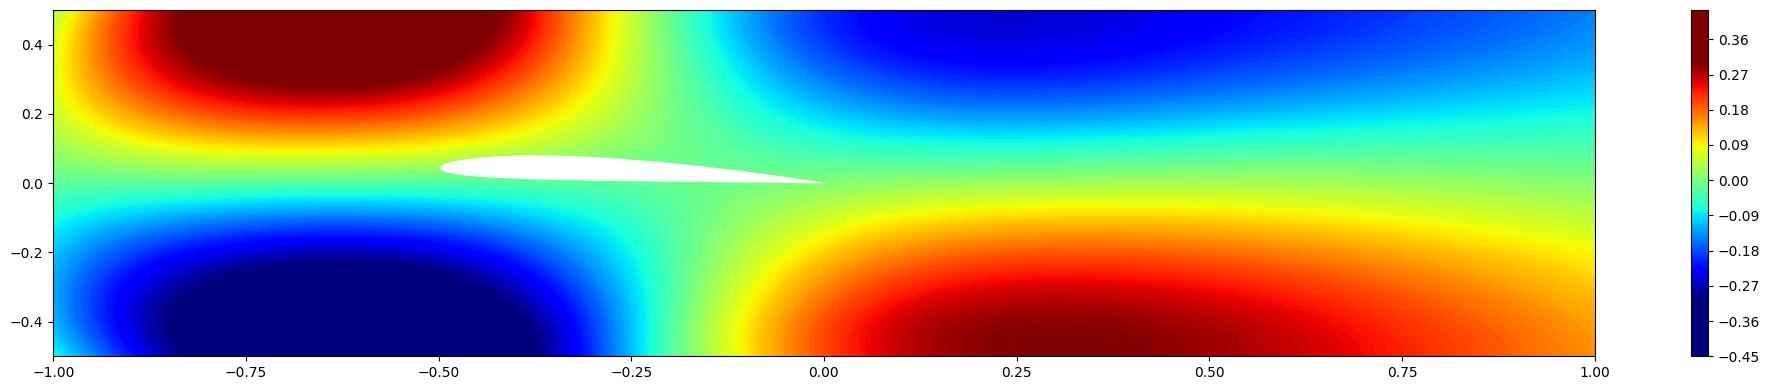

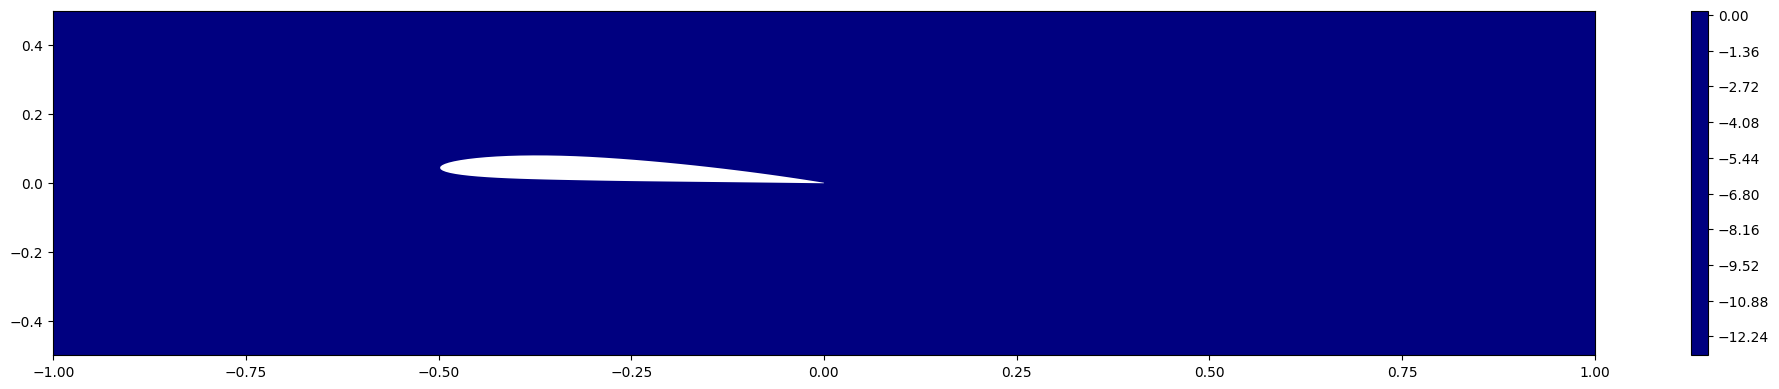

In [ ]:
dx = 0.01
dy = 0.01
x = np.arange(-L/2, L/2 + dx, dx)
y = np.arange(-D/2, D/2 + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

def getU(x, y):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def getV(x, y):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def getP(x, y):
    return y[:, 1:2]

# Model predictions generation
u = model.predict(X, operator = getU)
v = model.predict(X, operator = getV)
p = model.predict(X, operator = getP)

#for i in range(len(X)):
#    if airfoil.inside(np.array([X[i]]))[0]:
#        u[i] = 0.0
#        v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

result = [u, v, p]

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20, 4))
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)
  plt.fill_between(xnacarotate, ynacarotate, facecolor = 'w')
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()

#Train More--L-BFGS Optimizer

Compiling model...
'compile' took 2.356294 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
5000      [1.53e-03, 1.37e-03, 2.36e-03, 2.57e-03, 3.07e-03, 1.40e-04, 1.96e-02, 5.61e-03, 2.98e-03, 6.71e-02, 5.50e-04, 7.54e-03, 2.88e-02, 3.19e-04]    [1.40e-03, 1.46e-03, 1.87e-03, 2.25e-03, 6.12e-03, 1.31e-04, 1.96e-02, 5.61e-03, 2.98e-03, 6.71e-02, 5.50e-04, 7.54e-03, 2.88e-02, 3.19e-04]    []  
6000      [2.18e-04, 1.79e-04, 2.58e-04, 3.63e-04, 1.45e-03, 2.98e-05, 1.04e-02, 7.92e-04, 9.86e-03, 7.34e-02, 2.75e-05, 5.51e-03, 1.73e-02, 2.31e-04]    [2.18e-04, 1.79e-04, 2.58e-04, 3.63e-04, 1.45e-03, 2.98e-05, 1.04e-02, 7.92e-04, 9.86e-03, 7.34e-02, 2.75e-05, 5.51e-03, 1.73e-02, 2.31e-04]        
7000      [1.39e-04

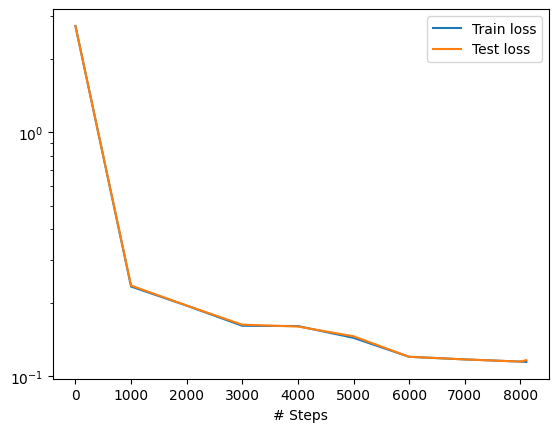

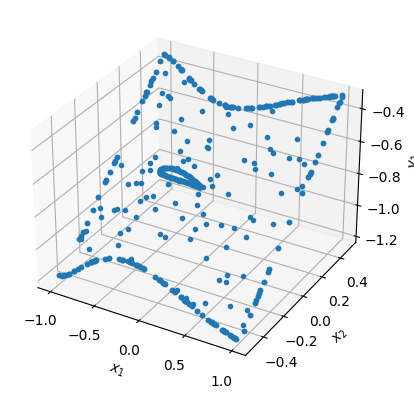

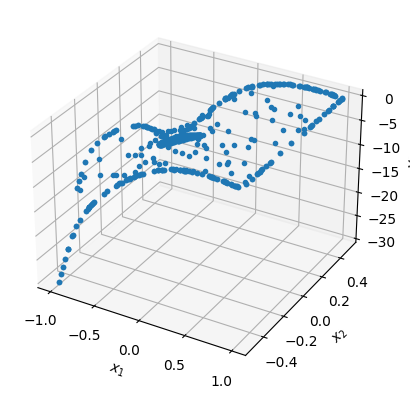

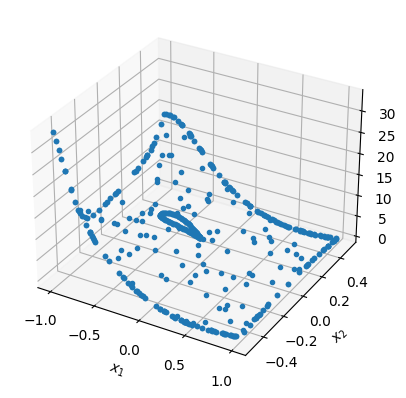

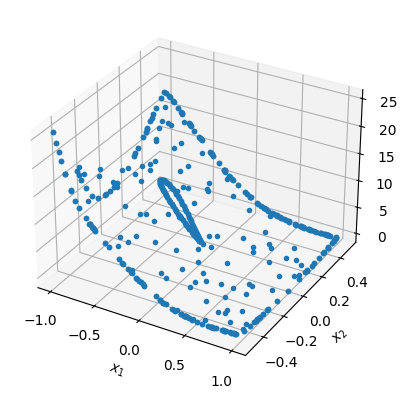

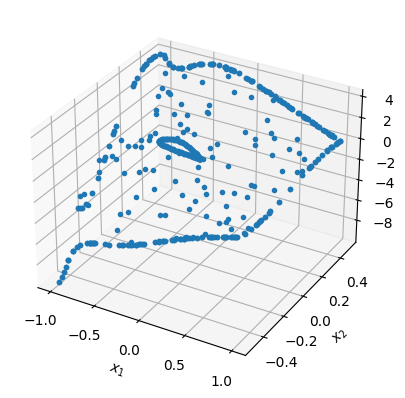

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)

model.compile('L-BFGS')
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

#Plot Results--ADAM + L-BFGS

<ipython-input-27-65460e15e715>:40: UserWarning: The following kwargs were not used by contour: 's'
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)


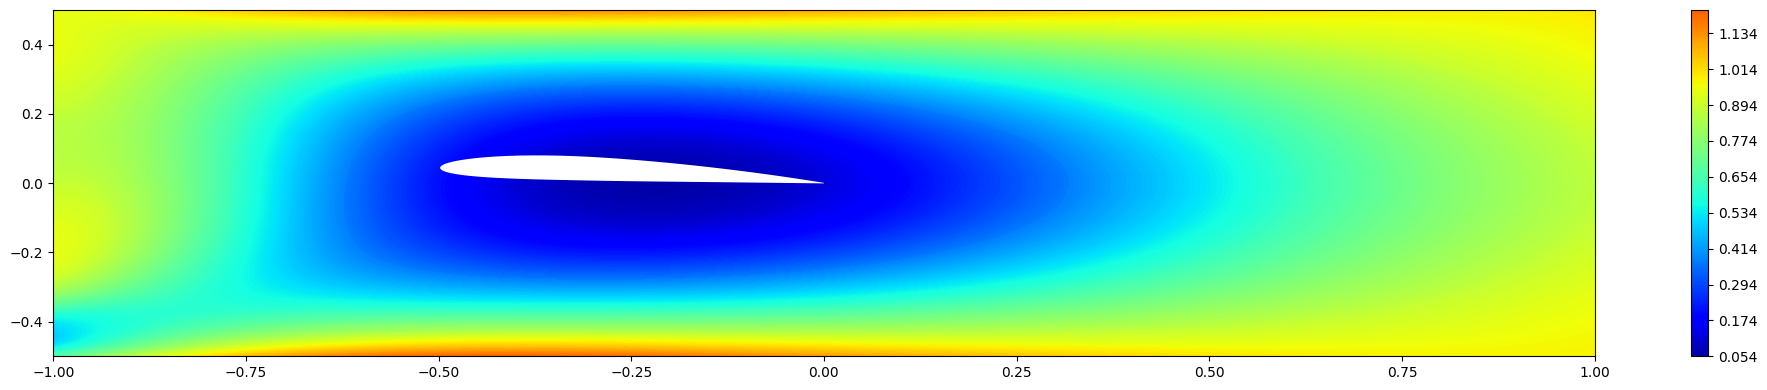

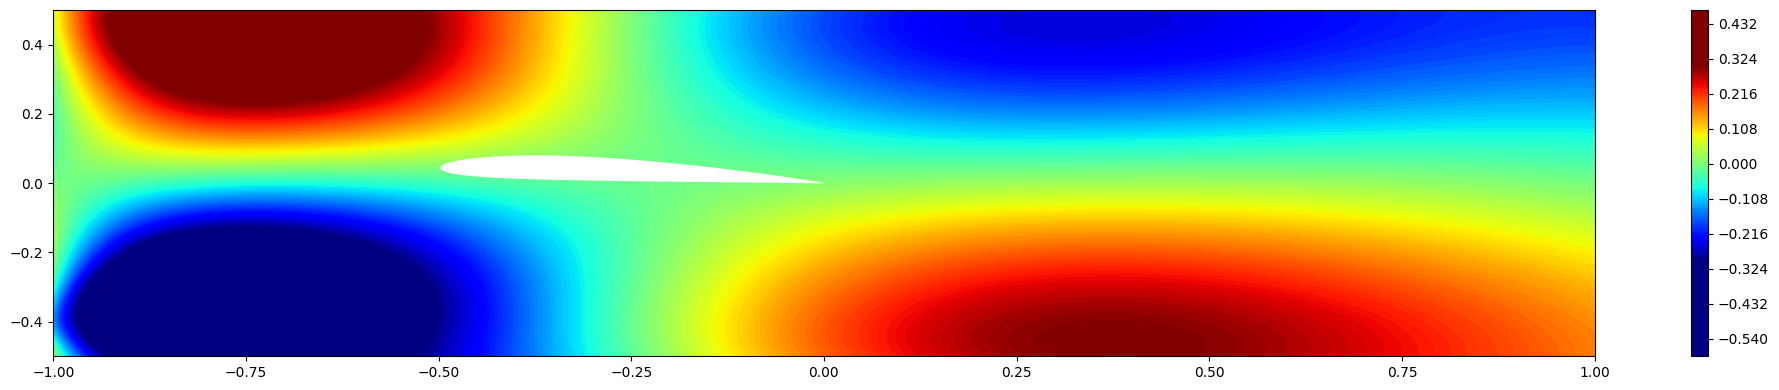

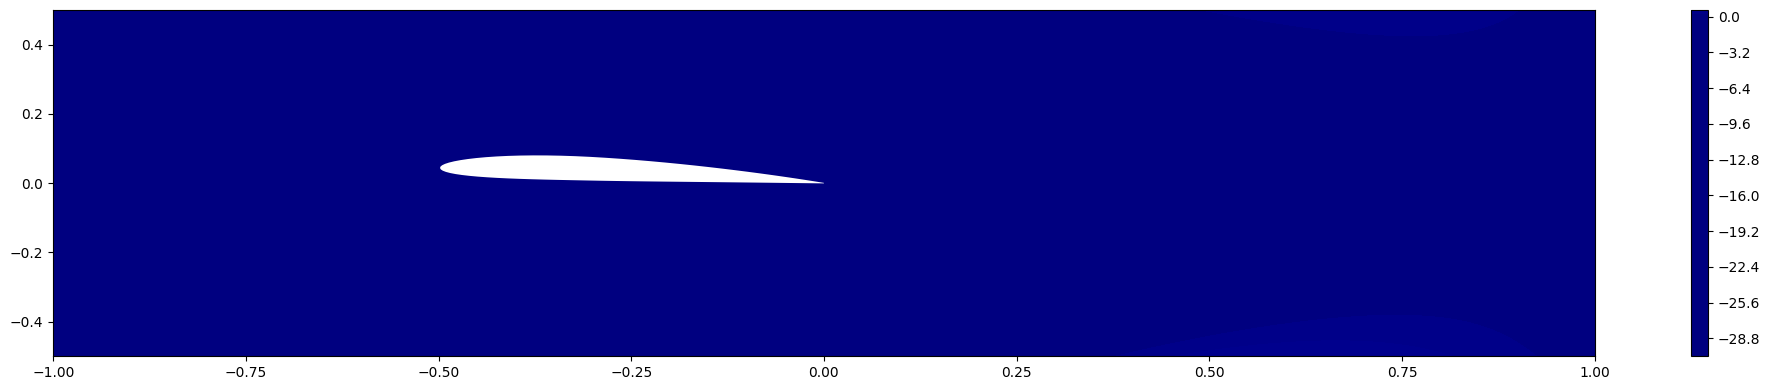

In [ ]:
dx = 0.01
dy = 0.01
x = np.arange(-L/2, L/2 + dx, dx)
y = np.arange(-D/2, D/2 + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

def getU(x, y):
    return dde.grad.jacobian(y, x, i = 0, j = 1)

def getV(x, y):
    return - dde.grad.jacobian(y, x, i = 0, j = 0)

def getP(x, y):
    return y[:, 1:2]

# Model predictions generation
u = model.predict(X, operator = getU)
v = model.predict(X, operator = getV)
p = model.predict(X, operator = getP)

#for i in range(len(X)):
#    if airfoil.inside(np.array([X[i]]))[0]:
#        u[i] = 0.0
#        v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

result = [u, v, p]

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
  plt.figure(figsize = (20, 4))
  plt.contourf(x, y, result[idx], len(x), cmap = 'jet', s = 2)
  plt.fill_between(xnacarotate, ynacarotate, facecolor = 'w')
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((-L/2, L/2))
  plt.ylim((-D/2, D/2))
  plt.tight_layout()
  plt.show()